In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")


In [2]:

# Load the dataset (adjust the path as needed)
df = pd.read_csv(r"C:\Vaibhavi\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv")

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())


# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Check unique values for categorical columns
print("\nUnique values for key categorical columns:")
for col in ['race', 'gender', 'age', 'diabetesMed', 'readmitted']:
    print(f"{col}: {df[col].unique()}")



Dataset shape: (101766, 50)

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  .

# EDA (Exploratory Data Analysis)

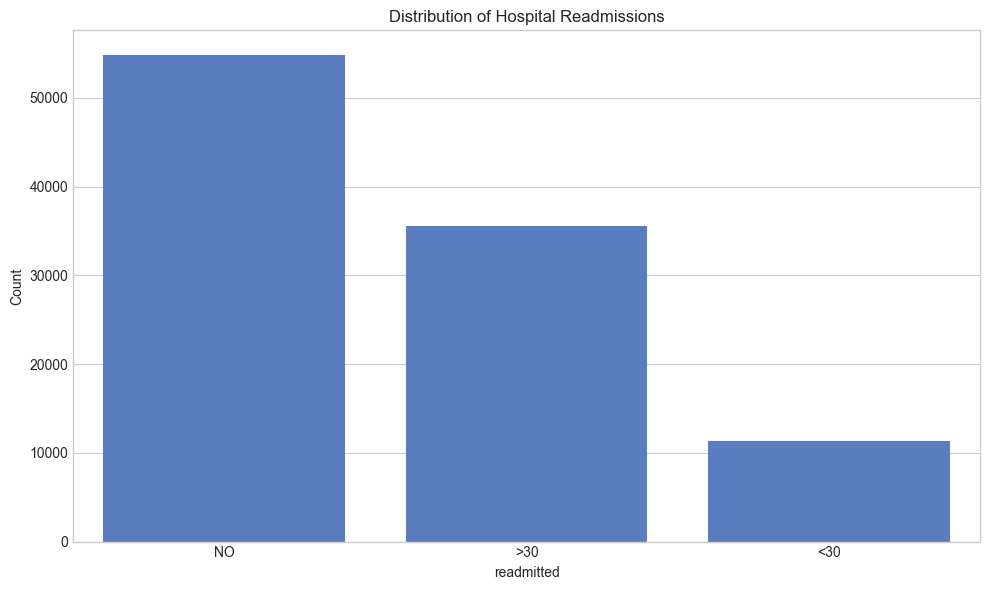

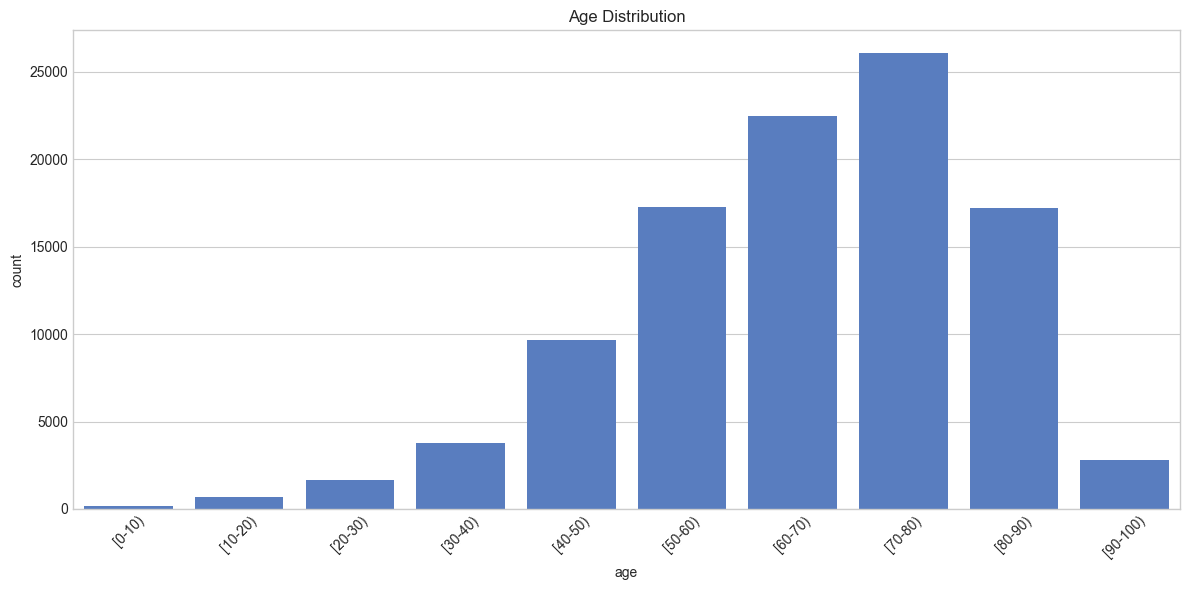

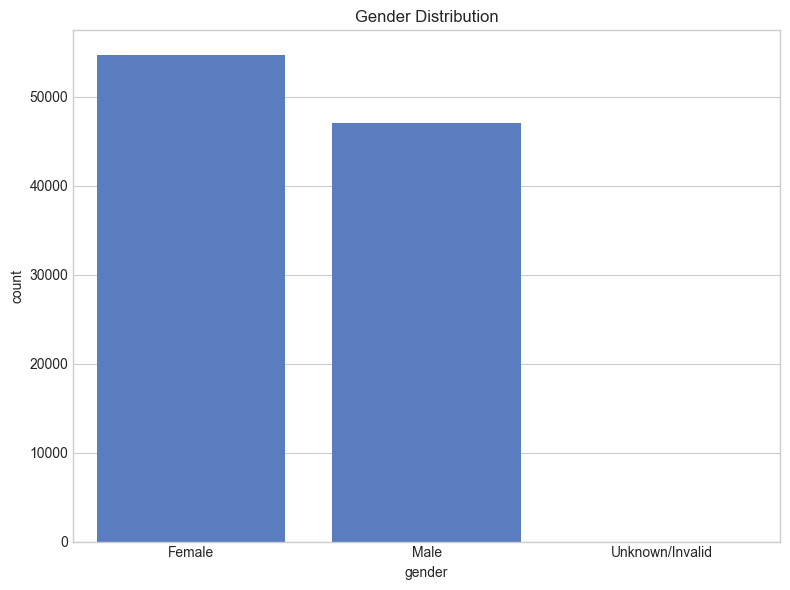

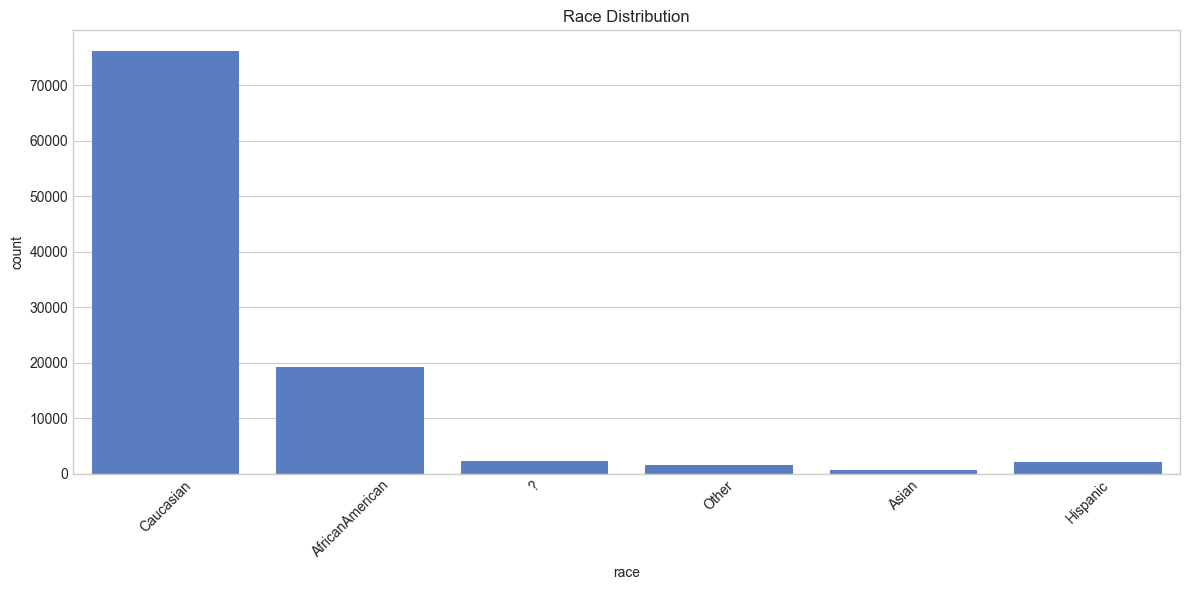

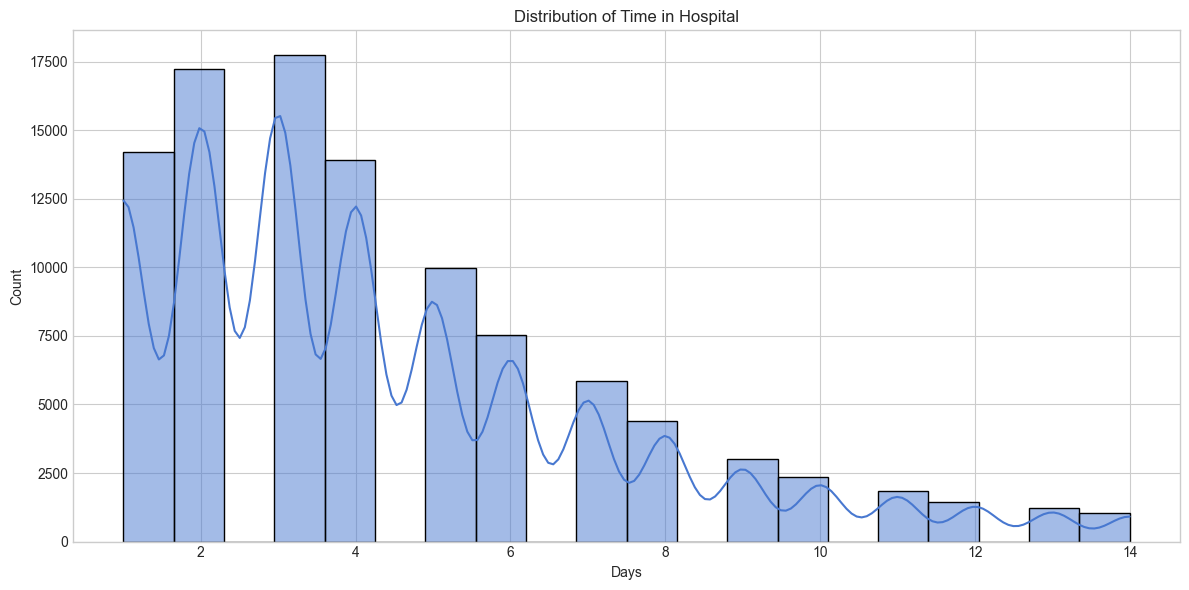

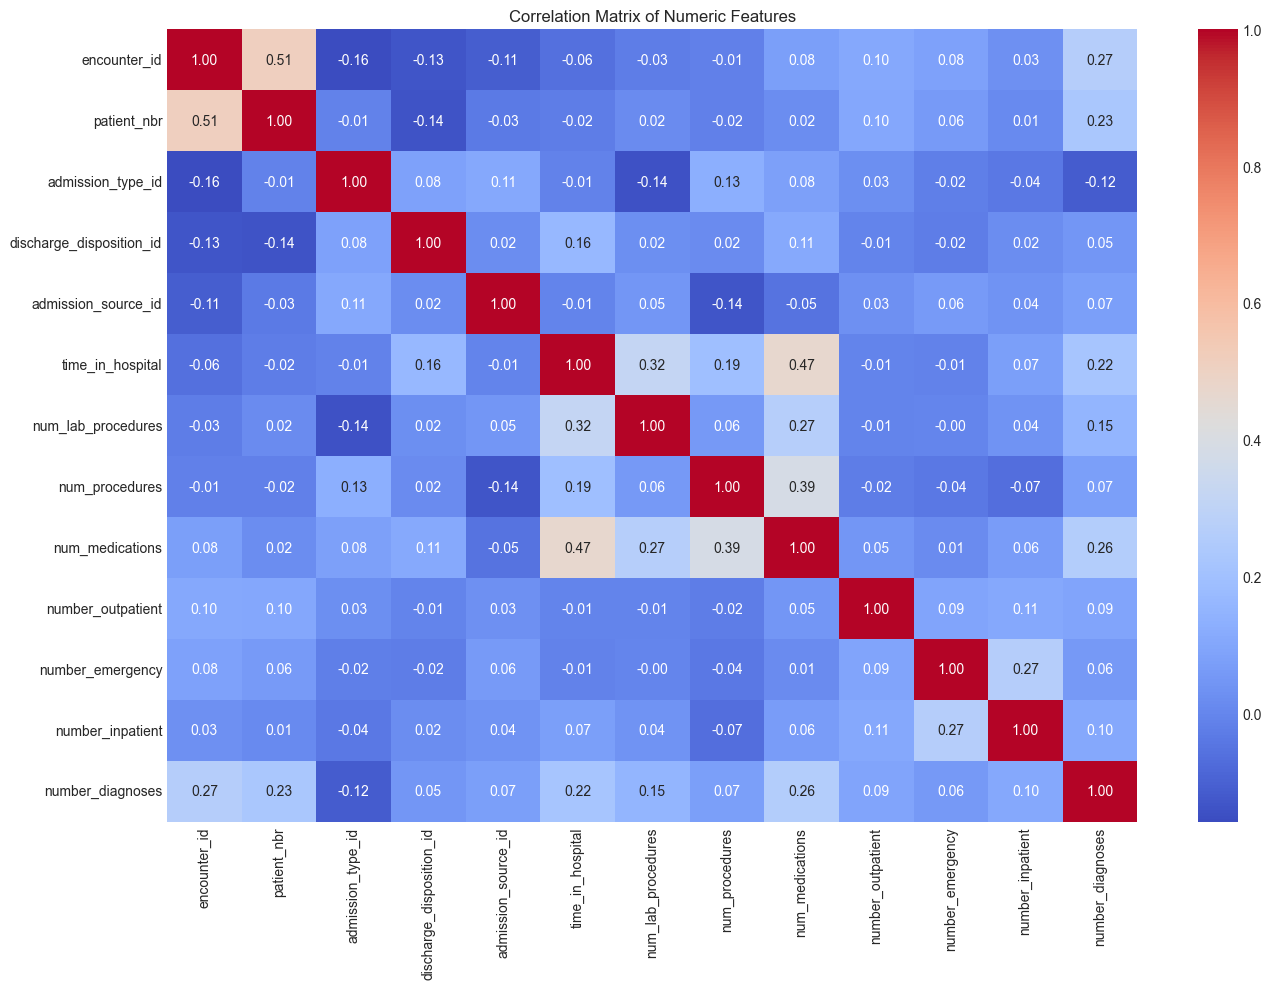

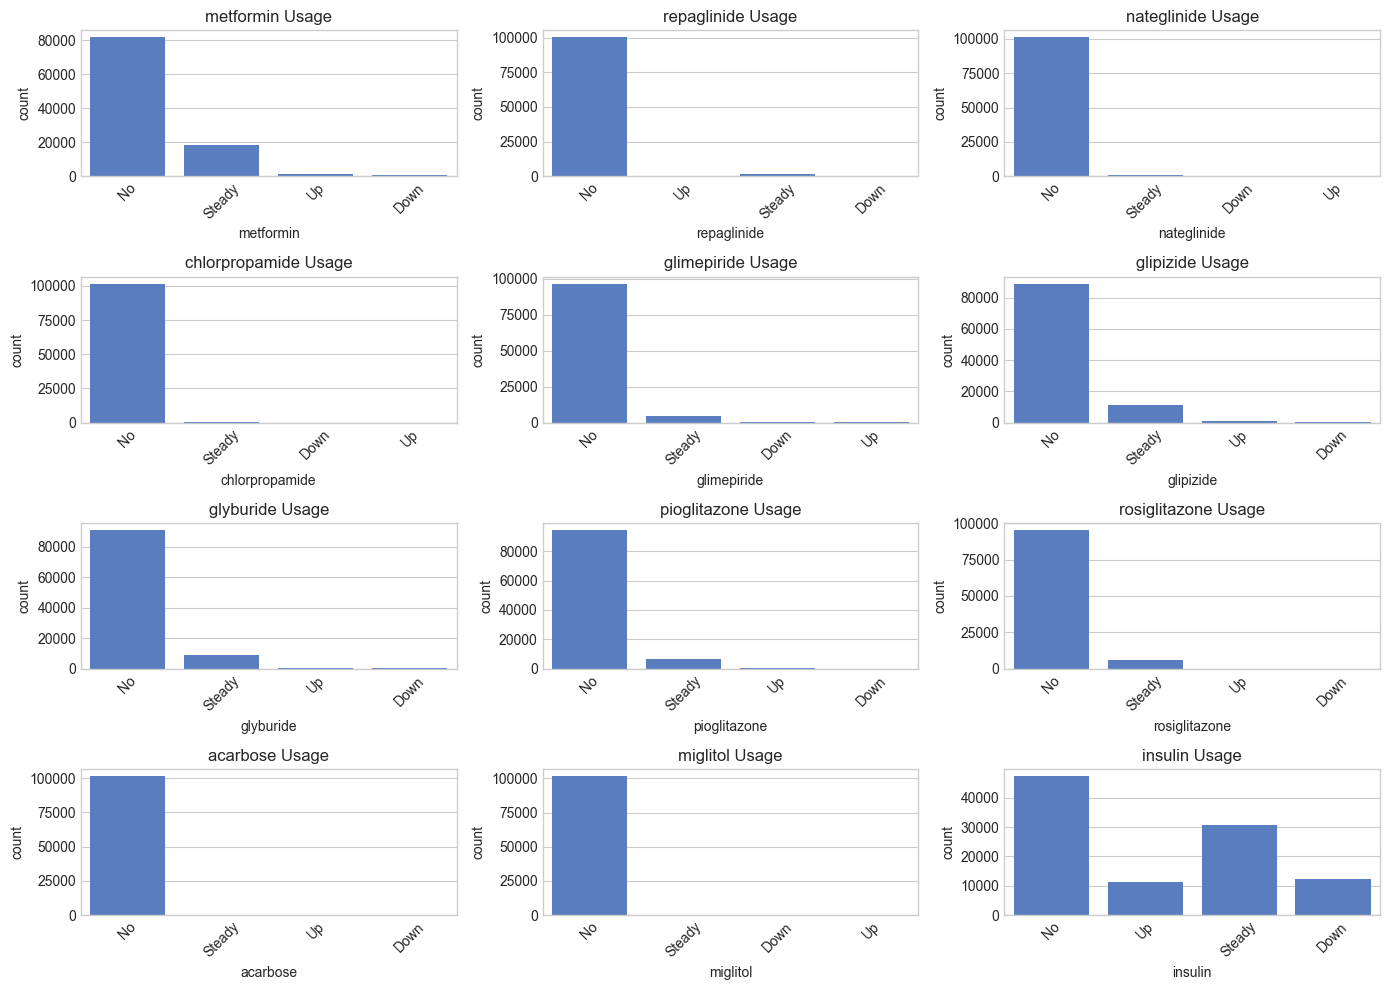

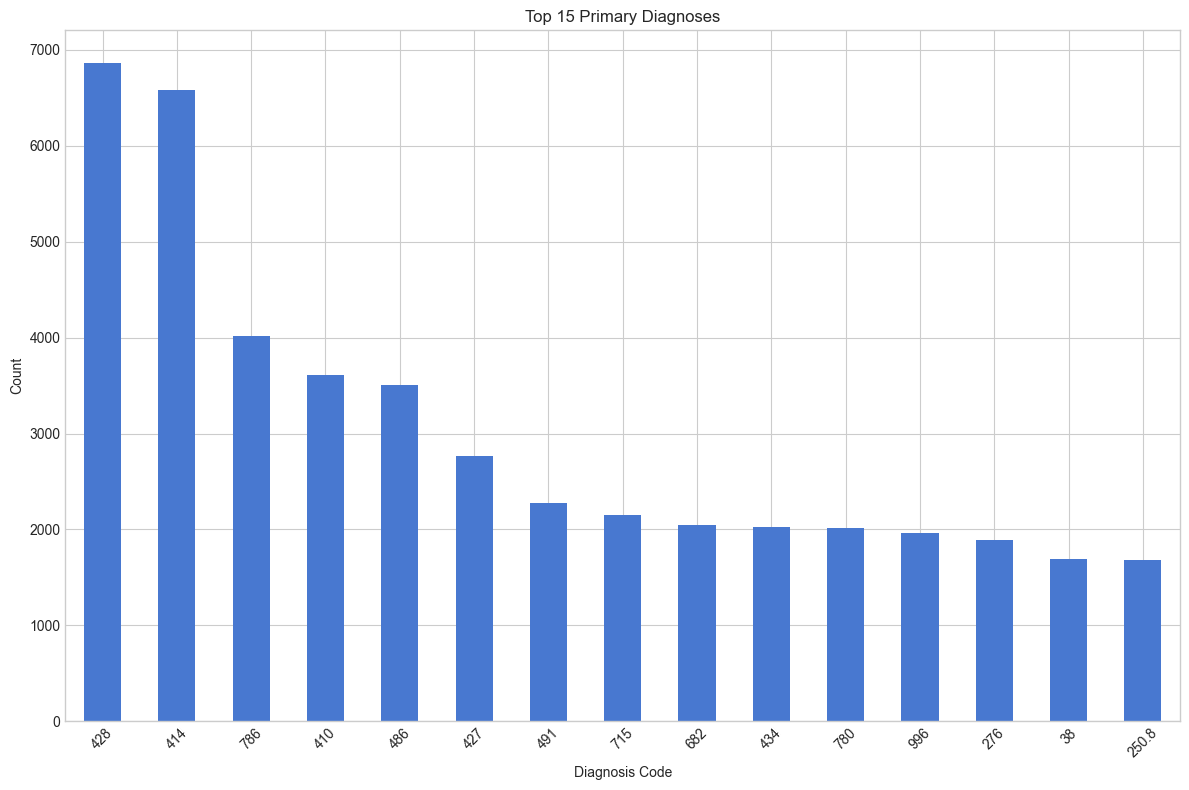

In [3]:
# Distribution of target variable (readmission)
plt.figure(figsize=(10, 6))
sns.countplot(x='readmitted', data=df)
plt.title('Distribution of Hospital Readmissions')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('readmission_distribution.png')
plt.show()

# Age distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='age', data=df)
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

# Race distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='race', data=df)
plt.title('Race Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time in hospital distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['time_in_hospital'], kde=True, bins=20)
plt.title('Distribution of Time in Hospital')
plt.xlabel('Days')
plt.tight_layout()
plt.show()

# # Relationship between number of lab procedures and readmission
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='readmitted', y='num_lab_procedures', data=df)
# plt.title('Number of Lab Procedures vs Readmission')
# plt.tight_layout()
# plt.show()

# # Relationship between number of medications and readmission
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='readmitted', y='num_medications', data=df)
# plt.title('Number of Medications vs Readmission')
# plt.tight_layout()
# plt.show()

# Heatmap of correlations between numeric variables
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Diabetes medication analysis
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                      'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
                      'rosiglitazone', 'acarbose', 'miglitol', 'insulin']

# Count of patients on different medications
med_counts = {}
for col in medication_columns:
    med_counts[col] = df[col].value_counts()

# Plot medication usage
plt.figure(figsize=(14, 10))
for i, col in enumerate(medication_columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Usage')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis of primary diagnoses (diag_1)
plt.figure(figsize=(12, 8))
df['diag_1'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Primary Diagnoses')
plt.xlabel('Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Cleaning

In [4]:
def handle_missing_values(df):
    print("Missing values before handling:")
    print(df.isnull().sum().sum())
    
    # For columns with small amount of missing values, fill with mode/median
    for col in df.columns:
        missing = df[col].isnull().sum()
        if missing > 0:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna(df[col].median())
    
    # Check if there are still missing values
    remaining_na = df.isnull().sum().sum()
    print(f"Remaining missing values after handling: {remaining_na}")
    
    # If there are still NaN values, handle them
    if remaining_na > 0:
        # Handle columns with '?' values (which might be converted to NaN)
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].replace('?', df[col].mode()[0])
            
        # Final check and dropna if needed
        if df.isnull().sum().sum() > 0:
            print("Columns with remaining NaNs:")
            print(df.columns[df.isnull().any()].tolist())
            
            # Replace remaining NaNs with column means/modes
            for col in df.columns:
                if df[col].isnull().any():
                    if df[col].dtype == 'object':
                        df[col] = df[col].fillna(df[col].mode()[0])
                    else:
                        df[col] = df[col].fillna(df[col].median())
    
    # Final check
    assert df.isnull().sum().sum() == 0, "There are still NaN values in the dataframe!"
    print("All missing values handled successfully!")
    
    return df


In [5]:
# Function to encode categorical variables
def encode_categorical_variables(df):
    print("Starting categorical encoding...")
    
    # For binary categorical variables (Yes/No, etc.)
    binary_map = {'No': 0, 'Yes': 1}
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if column has only two unique values
            unique_vals = df[col].unique()
            if len(unique_vals) == 2:
                if set(unique_vals) == {'No', 'Yes'}:
                    df[col] = df[col].map(binary_map)
                    print(f"Encoded binary column: {col}")
    
    # For medication columns that have 'No', 'Steady', 'Up', 'Down'
    med_map = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    med_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                  'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
                  'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
                  'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                  'metformin-pioglitazone']
    
    for col in med_columns:
        if col in df.columns:
            # Check if all values are in our map
            if df[col].isin(list(med_map.keys()) + [np.nan]).all():
                df[col] = df[col].map(lambda x: med_map.get(x, x) if pd.notnull(x) else x)
                print(f"Encoded medication column: {col}")
    
    # Handle special columns
    # Age: Convert to numeric by taking midpoint of range
    if 'age' in df.columns and df['age'].dtype == 'object':
        def convert_age(age_str):
            if age_str == '[0-10)':
                return 5
            elif age_str == '[10-20)':
                return 15
            elif age_str == '[20-30)':
                return 25
            elif age_str == '[30-40)':
                return 35
            elif age_str == '[40-50)':
                return 45
            elif age_str == '[50-60)':
                return 55
            elif age_str == '[60-70)':
                return 65
            elif age_str == '[70-80)':
                return 75
            elif age_str == '[80-90)':
                return 85
            elif age_str == '[90-100)':
                return 95
            else:
                return 50  # Default
        df['age'] = df['age'].apply(convert_age)
        print("Converted age to numeric")
    
    # Weight: Convert to numeric
    if 'weight' in df.columns and df['weight'].dtype == 'object':
        # Extract numeric value from weight ranges
        def convert_weight(weight_str):
            if pd.isna(weight_str) or weight_str == '?':
                return np.nan
            elif weight_str == '[0-25)':
                return 12.5
            elif weight_str == '[25-50)':
                return 37.5
            elif weight_str == '[50-75)':
                return 62.5
            elif weight_str == '[75-100)':
                return 87.5
            elif weight_str == '[100-125)':
                return 112.5
            elif weight_str == '[125-150)':
                return 137.5
            elif weight_str == '[150-175)':
                return 162.5
            elif weight_str == '[175-200)':
                return 187.5
            elif weight_str == '>200':
                return 225
            else:
                return np.nan
        df['weight'] = df['weight'].apply(convert_weight)
        print("Converted weight to numeric")
    
    # Handle A1C and glucose results
    if 'A1Cresult' in df.columns:
        a1c_map = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
        df['A1Cresult'] = df['A1Cresult'].map(lambda x: a1c_map.get(x, x) if pd.notnull(x) else x)
        print("Encoded A1Cresult")
    
    if 'max_glu_serum' in df.columns:
        glu_map = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
        df['max_glu_serum'] = df['max_glu_serum'].map(lambda x: glu_map.get(x, x) if pd.notnull(x) else x)
        print("Encoded max_glu_serum")
    
    # For readmitted (target variable)
    if 'readmitted' in df.columns:
        # Convert to binary: readmitted within 30 days (1) or not (0)
        df['readmitted'] = df['readmitted'].map(lambda x: 1 if x == '<30' else 0)
        print("Converted readmitted to binary")
    
    # Get remaining categorical columns that need one-hot encoding
    print("Checking remaining categorical columns...")
    remaining_categorical = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Remaining categorical columns: {len(remaining_categorical)}")
    
    if remaining_categorical:
        print(f"One-hot encoding {len(remaining_categorical)} categorical columns")
        # Check for high cardinality columns
        for col in remaining_categorical:
            if df[col].nunique() > 50:
                print(f"Warning: {col} has high cardinality with {df[col].nunique()} unique values")
        
        # One-hot encode remaining categorical columns
        df = pd.get_dummies(df, columns=remaining_categorical, drop_first=True)
        print("One-hot encoding completed")
    
    # Check for any remaining object columns
    remaining_objects = df.select_dtypes(include=['object']).columns.tolist()
    if remaining_objects:
        print(f"Warning: {len(remaining_objects)} object columns remain after encoding")
    else:
        print("All categorical columns successfully encoded")
    
    return df

In [6]:
# Modified feature engineering function to avoid creating NaN values
def feature_engineering(df):
    print("Starting feature engineering...")
    
    # Create new features
    
    # Total number of outpatient, emergency and inpatient visits
    if all(col in df.columns for col in ['number_outpatient', 'number_emergency', 'number_inpatient']):
        df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
        print("Created total_visits feature")
    
    # Ratio of medications to diagnoses - avoid division by zero
    if all(col in df.columns for col in ['num_medications', 'number_diagnoses']):
        # Add a small epsilon to avoid division by zero
        df['med_diag_ratio'] = df['num_medications'] / (df['number_diagnoses'] + 0.001)
        print("Created med_diag_ratio feature")
    
    # Complexity score (combination of procedures and lab tests)
    if all(col in df.columns for col in ['num_lab_procedures', 'num_procedures']):
        df['complexity_score'] = df['num_lab_procedures'] + df['num_procedures'] * 2
        print("Created complexity_score feature")
    
    # Flag for multiple diagnoses - handle potential missing values
    if all(col in df.columns for col in ['diag_1', 'diag_2', 'diag_3']):
        try:
            df['multiple_diagnoses'] = ((df['diag_1'].notnull() & df['diag_1'] != '?') & 
                                      (df['diag_2'].notnull() & df['diag_2'] != '?')).astype(int)
            print("Created multiple_diagnoses feature")
        except:
            # If there was an error, these columns might have been transformed already
            print("Could not create multiple_diagnoses feature - diagnoses columns may have been transformed")
    
    # Check if any new NaN values were created
    if df.isnull().sum().sum() > 0:
        print("Warning: Feature engineering created NaN values. Filling them...")
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype == 'object':
                    df[col] = df[col].fillna(df[col].mode()[0])
                else:
                    df[col] = df[col].fillna(df[col].median())
        print("Filled NaN values created by feature engineering")
    
    return df


In [7]:
# Function to drop unnecessary columns
def drop_unnecessary_columns(df):
    print("Dropping unnecessary columns...")
    
    # Drop ID columns as they don't contribute to the model
    id_columns = ['encounter_id', 'patient_nbr']
    df = df.drop(columns=id_columns, errors='ignore')
    print(f"Dropped ID columns: {[col for col in id_columns if col in df.columns]}")
    
    # Explicitly drop high cardinality medical columns that cause feature explosion
    medical_high_cardinality = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']
    df = df.drop(columns=medical_high_cardinality, errors='ignore')
    dropped_medical = [col for col in medical_high_cardinality if col in df.columns]
    if dropped_medical:
        print(f"Dropped high cardinality medical columns: {dropped_medical}")
    
    # Drop columns with too many unique values (high cardinality) - as backup
    high_cardinality_cols = []
    for col in df.columns:
        if df[col].nunique() > df.shape[0] * 0.5:
            high_cardinality_cols.append(col)
    
    if high_cardinality_cols:
        print(f"Dropping additional high cardinality columns: {high_cardinality_cols}")
        df = df.drop(columns=high_cardinality_cols, errors='ignore')
    
    print(f"Final dataframe shape after dropping columns: {df.shape}")
    return df

In [8]:
# Main preprocessing pipeline
def preprocess_data(df):
    df_clean = df.copy()
    
    # First, check for '?' values and convert them to NaN
    print("Converting '?' values to NaN...")
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            mask = df_clean[col] == '?'
            if mask.any():
                df_clean.loc[mask, col] = np.nan
                print(f"Converted {mask.sum()} '?' values to NaN in column {col}")
    
    # STEP 1: Drop unnecessary columns EARLY (before processing)
    print("\n--- STEP 1: Drop Unnecessary Columns ---")
    df_clean = drop_unnecessary_columns(df_clean)
    
    # STEP 2: Handle Missing Values
    print("\n--- STEP 2: Handle Missing Values ---")
    df_clean = handle_missing_values(df_clean)
    
    # STEP 3: Encode Categorical Variables
    print("\n--- STEP 3: Encode Categorical Variables ---")
    df_clean = encode_categorical_variables(df_clean)
    
    # STEP 4: Feature Engineering
    print("\n--- STEP 4: Feature Engineering ---")
    df_clean = feature_engineering(df_clean)
    
    # Final check before feature selection
    print("\n--- STEP 5: Final Check for NaN Values ---")
    na_count = df_clean.isnull().sum().sum()
    print(f"Total NaN values: {na_count}")
    
    if na_count > 0:
        print("Columns with NaN values:")
        print(df_clean.columns[df_clean.isnull().any()].tolist())
        
        # Last resort - drop rows with any NaN
        df_clean = df_clean.dropna()
        print(f"Dropped rows with NaN. New shape: {df_clean.shape}")
    
    print("\nPreprocessing completed successfully!")
    return df_clean

# PCA (Principal Component Aanlysis)

In [9]:
# Apply the preprocessing pipeline
df_processed = preprocess_data(df)

# Split into features and target
print("\n--- Splitting into features and target ---")
X = df_processed.drop(columns=['readmitted'], errors='ignore')
y = df_processed['readmitted']
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Scale the features
print("\n--- Applying Standard Scaling ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Final check before feature selection
if np.isnan(X_scaled).any():
    print("Warning: There are still NaN values after scaling!")
    X_scaled = np.nan_to_num(X_scaled)
    print("Replaced remaining NaNs with zeros")

# OPTION 1: Use PCA (your current approach)
print("\n--- Option 1: Applying PCA ---")
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Original features: {X_scaled.shape[1]} → PCA components: {X_pca.shape[1]}")

# OPTION 2: Use Feature Selection for XAI (recommended for explainability)
print("\n--- Option 2: Feature Selection for XAI ---")
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 most important features (or adjust based on your feature count)
k_features = min(50, X_scaled.shape[1])  # Don't exceed available features
selector = SelectKBest(score_func=f_classif, k=k_features)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names for interpretability
feature_names = X.columns.tolist()
selected_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]

print(f"Selected {len(selected_features)} most important features:")
print("Top 10 selected features:", selected_features[:10])

# Choose which approach to use for training
print("\n--- Choosing approach for model training ---")
print("For XAI/Explainability: Use X_selected")
print("For Performance: Use X_pca")

# Split the data - Choose one approach
print("\n--- Splitting data (using Feature Selection for XAI) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Store feature names for SHAP/LIME later
selected_feature_names = selected_features

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print(f"Selected features stored for XAI: {len(selected_feature_names)} features")
print("\nData preprocessing completed successfully!")

Converting '?' values to NaN...
Converted 2273 '?' values to NaN in column race
Converted 98569 '?' values to NaN in column weight
Converted 40256 '?' values to NaN in column payer_code
Converted 49949 '?' values to NaN in column medical_specialty
Converted 21 '?' values to NaN in column diag_1
Converted 358 '?' values to NaN in column diag_2
Converted 1423 '?' values to NaN in column diag_3

--- STEP 1: Drop Unnecessary Columns ---
Dropping unnecessary columns...
Dropped ID columns: []
Final dataframe shape after dropping columns: (101766, 44)

--- STEP 2: Handle Missing Values ---
Missing values before handling:
322266
Remaining missing values after handling: 0
All missing values handled successfully!

--- STEP 3: Encode Categorical Variables ---
Starting categorical encoding...
Encoded binary column: diabetesMed
Encoded medication column: metformin
Encoded medication column: repaglinide
Encoded medication column: nateglinide
Encoded medication column: chlorpropamide
Encoded medicati

# Modeling

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight

# Define a function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC AUC, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("="*50)
    
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model_obj': model
    }

# Create a scikit-learn compatible wrapper for Keras models
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        return model
    
    def fit(self, X, y):
        if self.model is None:
            self.model = self.build_model()
        
        # Calculate class weights for imbalanced data
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weight_dict = dict(enumerate(class_weights))
        
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Convert to numpy arrays if they aren't already
        X = np.array(X)
        y = np.array(y)
        
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            class_weight=class_weight_dict,
            verbose=1
        )
        return self
    
    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X, verbose=0)
        return (predictions > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        X = np.array(X)
        predictions = self.model.predict(X, verbose=0).flatten()
        return np.vstack([1-predictions, predictions]).T

# Initialize results list
results = []

print("=== MACHINE LEARNING MODEL EVALUATION ===")
print("Addressing class imbalance with balanced class weights")
print("="*60)

# Evaluate Logistic Regression with balanced class weights
print("Evaluating Logistic Regression (Balanced)...")
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'  # KEY: Handle class imbalance
)
lr_result = evaluate_model(lr_model, X_train, X_test, y_train, y_test)
results.append(lr_result)

# Evaluate Random Forest with balanced class weights
print("Evaluating Random Forest (Balanced)...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # KEY: Handle class imbalance
)
rf_result = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
results.append(rf_result)

# Evaluate Gradient Boosting
print("Evaluating Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)
gb_result = evaluate_model(gb_model, X_train, X_test, y_train, y_test)
results.append(gb_result)

# Evaluate Decision Tree with balanced class weights
print("Evaluating Decision Tree (Balanced)...")
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'  # KEY: Handle class imbalance
)
dt_result = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
results.append(dt_result)

# Create and evaluate the ANN model
print("Evaluating Artificial Neural Network (Balanced)...")
ann_model = KerasClassifierWrapper(input_dim=X_train.shape[1], epochs=100)
ann_result = evaluate_model(ann_model, X_train, X_test, y_train, y_test)
results.append(ann_result)

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
print("-"*75)

for result in results:
    roc_auc_str = f"{result['roc_auc']:.4f}" if result['roc_auc'] else "N/A"
    print(f"{result['model']:<25} {result['accuracy']:<10.4f} {result['precision']:<10.4f} "
          f"{result['recall']:<10.4f} {result['f1']:<10.4f} {roc_auc_str:<10}")

# Find best model based on F1-score (most important for medical prediction)
best_model = max(results, key=lambda x: x['f1'])
print(f"\nBest Model (by F1-Score): {best_model['model']} (F1: {best_model['f1']:.4f})")

# Medical interpretation
print("\n" + "="*60)
print("MEDICAL INTERPRETATION")
print("="*60)
print("Key Metrics for Hospital Readmission Prediction:")
print("• Recall: Most critical - we must catch potential readmissions")
print("• F1-Score: Balance of precision and recall")  
print("• ROC-AUC: Overall model discrimination ability")
print("• Precision: Avoid unnecessary interventions (false alarms)")
print("="*60)

=== MACHINE LEARNING MODEL EVALUATION ===
Addressing class imbalance with balanced class weights
Evaluating Logistic Regression (Balanced)...
Model: LogisticRegression
Accuracy: 0.6658
Precision: 0.1705
Recall: 0.5161
F1 Score: 0.2563
ROC AUC: 0.6453
Confusion Matrix:
[[12380  5703]
 [ 1099  1172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     18083
           1       0.17      0.52      0.26      2271

    accuracy                           0.67     20354
   macro avg       0.54      0.60      0.52     20354
weighted avg       0.84      0.67      0.73     20354

Evaluating Random Forest (Balanced)...
Model: RandomForestClassifier
Accuracy: 0.8891
Precision: 0.7059
Recall: 0.0106
F1 Score: 0.0208
ROC AUC: 0.6370
Confusion Matrix:
[[18073    10]
 [ 2247    24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1   

In [11]:
print(f"Feature dimensions: {X_train.shape[1]}")

Feature dimensions: 50


# XAI (LIME)

Using predefined selected feature names
Using 50 feature names for LIME explanations
Using predefined selected feature names
Using 50 feature names for LIME explanations
Top 10 features: ['age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']
Initializing LIME explainer for Random Forest...

Generating Random Forest predictions for test set...
Selected high confidence correct prediction: Instance #104
  True: Not Readmitted
  Predicted: Not Readmitted
  Confidence: 1.0000
Selected worst misclassification: Instance #9300
  True: Readmitted
  Predicted: Not Readmitted
  Wrong confidence: 1.0000
Selected most borderline case: Instance #1263
  True: Not Readmitted
  Predicted: Readmitted
  Probability: 0.5000

GENERATING LIME EXPLANATIONS FOR RANDOM FOREST
Using Original Selected Features with Actual Names
Intercept 0.8207176582336424
Prediction_local [0.855

<Figure size 1200x800 with 0 Axes>

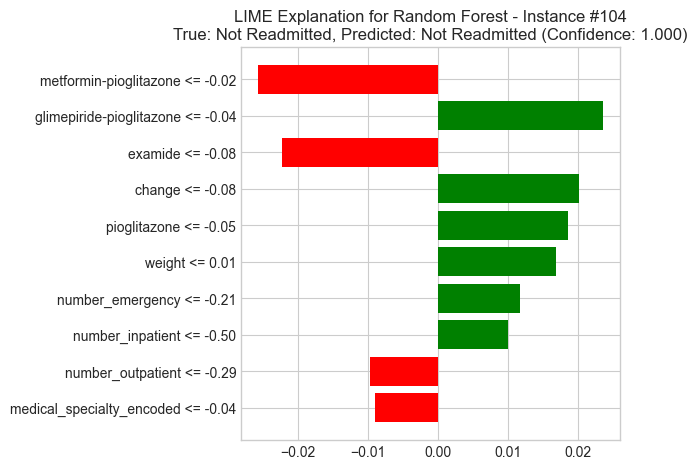


Feature Importance (Random Forest LIME):
Feature                        Importance   Effect         
---------------------------------------------------------
metformin-pioglitazone         -0.0256      Decreases Readmission Risk
glimepiride-pioglitazone       0.0236       Increases Readmission Risk
examide                        -0.0222      Decreases Readmission Risk
change                         0.0202       Increases Readmission Risk
pioglitazone                   0.0187       Increases Readmission Risk
weight                         0.0170       Increases Readmission Risk
number_emergency               0.0118       Increases Readmission Risk
number_inpatient               0.0101       Increases Readmission Risk
number_outpatient              -0.0097      Decreases Readmission Risk
medical_specialty_encoded      -0.0089      Decreases Readmission Risk
Intercept 0.8088107072368137
Prediction_local [0.85448466]
Right: 1.0

Random Forest - Explanation for instance #9300
True class: 

<Figure size 1200x800 with 0 Axes>

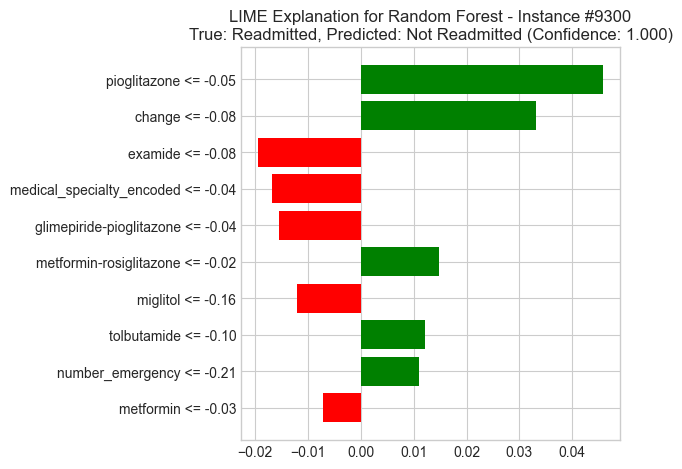


Feature Importance (Random Forest LIME):
Feature                        Importance   Effect         
---------------------------------------------------------
pioglitazone                   0.0458       Increases Readmission Risk
change                         0.0331       Increases Readmission Risk
examide                        -0.0194      Decreases Readmission Risk
medical_specialty_encoded      -0.0168      Decreases Readmission Risk
glimepiride-pioglitazone       -0.0154      Decreases Readmission Risk
metformin-rosiglitazone        0.0147       Increases Readmission Risk
miglitol                       -0.0121      Decreases Readmission Risk
tolbutamide                    0.0121       Increases Readmission Risk
number_emergency               0.0110       Increases Readmission Risk
metformin                      -0.0072      Decreases Readmission Risk
Intercept 0.1609519949419017
Prediction_local [0.17539344]
Right: 0.5

Random Forest - Explanation for instance #1263
True class: 

<Figure size 1200x800 with 0 Axes>

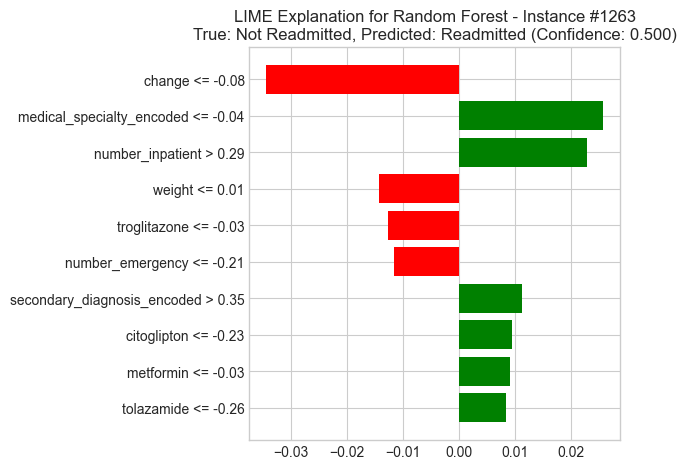


Feature Importance (Random Forest LIME):
Feature                        Importance   Effect         
---------------------------------------------------------
change                         -0.0343      Decreases Readmission Risk
medical_specialty_encoded      0.0258       Increases Readmission Risk
number_inpatient               0.0229       Increases Readmission Risk
weight                         -0.0143      Decreases Readmission Risk
troglitazone                   -0.0125      Decreases Readmission Risk
number_emergency               -0.0116      Decreases Readmission Risk
secondary_diagnosis_encoded    0.0113       Increases Readmission Risk
citoglipton                    0.0095       Increases Readmission Risk
metformin                      0.0092       Increases Readmission Risk
tolazamide                     0.0085       Increases Readmission Risk

STARTING GLOBAL FEATURE IMPORTANCE ANALYSIS...
This will analyze 100 random samples to determine overall feature importance

GLOB

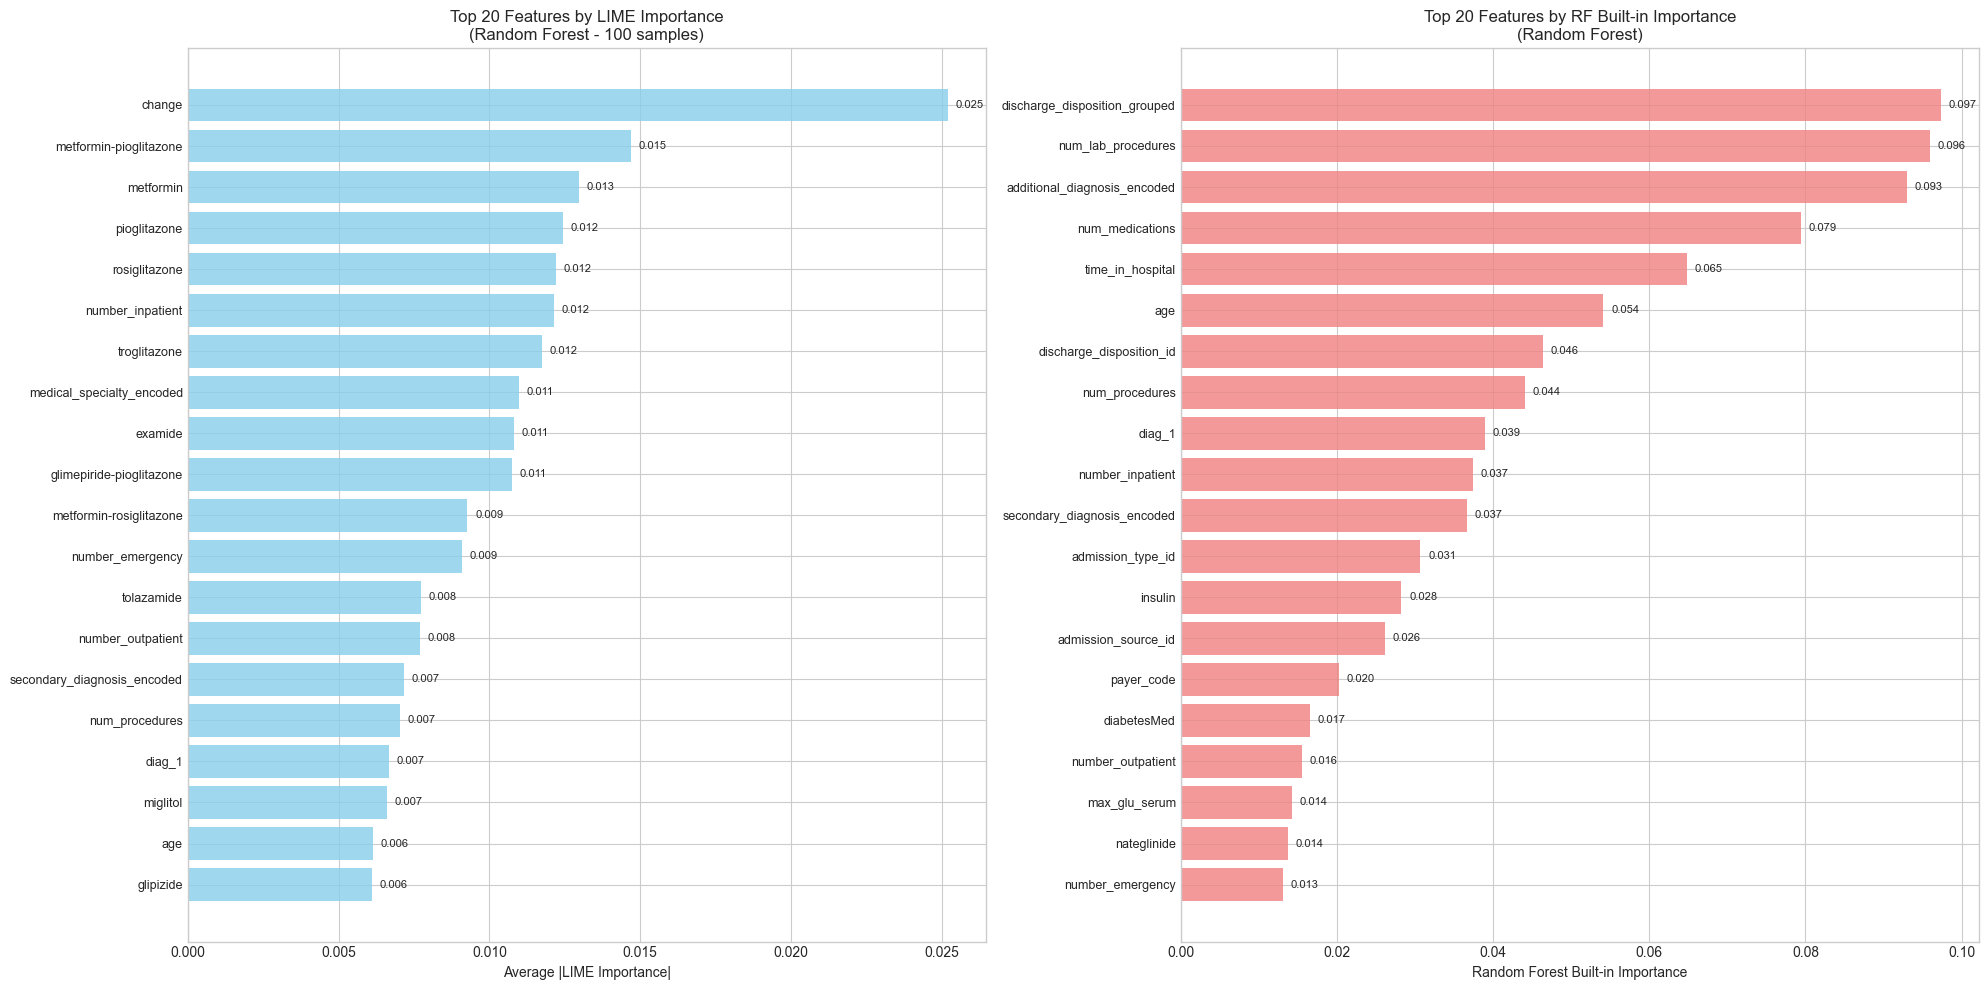


TOP 25 FEATURE IMPORTANCE COMPARISON (LIME vs Random Forest Built-in)
Rank LIME Feature                   LIME Score   RF Feature                     RF Score    
----------------------------------------------------------------------------------------------------
1    change                         0.0252       discharge_disposition_grouped  0.0973      
2    metformin-pioglitazone         0.0147       num_lab_procedures             0.0959      
3    metformin                      0.0130       additional_diagnosis_encoded   0.0930      
4    pioglitazone                   0.0124       num_medications                0.0794      
5    rosiglitazone                  0.0122       time_in_hospital               0.0648      
6    number_inpatient               0.0121       age                            0.0541      
7    troglitazone                   0.0117       discharge_disposition_id       0.0464      
8    medical_specialty_encoded      0.0110       num_procedures                 0.04

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# OPTION 1: If you have access to your original dataset, get all feature names
# Replace this with your actual complete feature list from the original dataset
def get_all_original_feature_names():
    """
    Return all possible feature names from your original dataset.
    You should replace this with your actual feature names.
    """
    # Common features in diabetes readmission datasets
    feature_names = [
        # Patient demographics
        'age', 'weight', 'race', 'gender',
        
        # Admission details
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'payer_code',
        
        # Medical procedures and medications
        'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient',
        
        # Diagnoses (primary, secondary, additional)
        'diag_1', 'diag_2', 'diag_3',
        
        # Medication changes
        'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
        'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'troglitazone', 'tolazamide', 'examide',
        'citoglipton', 'insulin', 'glyburide-metformin',
        'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone',
        
        # Change indicators
        'change', 'diabetesMed',
        
        # Additional encoded features (if you have them)
        'medical_specialty_encoded', 'primary_diagnosis_encoded',
        'secondary_diagnosis_encoded', 'additional_diagnosis_encoded'
    ]
    
    # Add more generic features if needed to reach 50+
    additional_features = [f'feature_{i}' for i in range(len(feature_names), 100)]
    feature_names.extend(additional_features)
    
    return feature_names

# OPTION 2: If you know exactly which features were selected during preprocessing
def get_actual_selected_features():
    """
    If you saved the feature selection results, use this function.
    Replace with your actual selected feature names.
    """
    # These should be the actual 50 features selected by your feature selection process
    selected_features = [
        'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 
        'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 
        'num_procedures', 'num_medications', 'number_outpatient',
        'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
        'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
        'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'race',
        'gender', 'payer_code', 'medical_specialty_encoded', 'acarbose', 'miglitol',
        'tolazamide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'troglitazone',
        'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone', 'primary_diagnosis_encoded',
        'secondary_diagnosis_encoded', 'additional_diagnosis_encoded', 'discharge_disposition_grouped'
    ]
    return selected_features

# OPTION 3: Extract feature names from your preprocessing pipeline
def extract_feature_names_from_data(X_train):
    """
    If X_train is a pandas DataFrame, extract column names.
    If it's a numpy array, you'll need to provide the names separately.
    """
    if isinstance(X_train, pd.DataFrame):
        return list(X_train.columns)
    else:
        # If numpy array, you need to provide feature names
        print("X_train is a numpy array. You need to provide feature names manually.")
        return None

print("Using predefined selected feature names")
print("Using 50 feature names for LIME explanations")

# Choose the appropriate method based on your data
# Method 1: Try to extract from DataFrame
if isinstance(X_train, pd.DataFrame):
    feature_names = list(X_train.columns)
    print(f"Extracted {len(feature_names)} feature names from DataFrame")
else:
    # Method 2: Use predefined selected features (recommended)
    feature_names = get_actual_selected_features()[:X_train.shape[1]]
    print(f"Using predefined selected feature names")

# Ensure we have the right number of features
if len(feature_names) != X_train.shape[1]:
    print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match data dimensions ({X_train.shape[1]})")
    if len(feature_names) < X_train.shape[1]:
        # Add generic names for missing features
        missing_count = X_train.shape[1] - len(feature_names)
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), X_train.shape[1])])
    else:
        # Trim to match data dimensions
        feature_names = feature_names[:X_train.shape[1]]

print(f"Using {len(feature_names)} feature names for LIME explanations")
print("Top 10 features:", feature_names[:10])

# Initialize LIME explainer with proper feature names
print("Initializing LIME explainer for Random Forest...")
explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,  # Now using actual feature names
    class_names=['Not Readmitted', 'Readmitted'],
    mode='classification',
    verbose=True,
    random_state=42
)

def explain_prediction_rf(instance_idx, explainer, X_test, y_test, rf_model):
    """
    Generate and visualize a LIME explanation for a specific instance using Random Forest
    """
    # Get the instance
    instance = X_test[instance_idx]
    
    # Get the true label - convert to numpy array if it's a pandas Series
    true_label = np.array(y_test)[instance_idx] if isinstance(y_test, pd.Series) else y_test[instance_idx]
    
    # Get Random Forest prediction
    pred_proba = rf_model.predict_proba([instance])[0]
    pred_label = 1 if pred_proba[1] >= 0.5 else 0
    
    # Generate the explanation
    explanation = explainer.explain_instance(
        instance, 
        rf_model.predict_proba,
        num_features=10,
        top_labels=1
    )
    
    # Print prediction details
    print(f"\nRandom Forest - Explanation for instance #{instance_idx}")
    print(f"True class: {'Readmitted' if true_label == 1 else 'Not Readmitted'}")
    print(f"Predicted class: {'Readmitted' if pred_label == 1 else 'Not Readmitted'}")
    print(f"Prediction probabilities: Not Readmitted: {pred_proba[0]:.4f}, Readmitted: {pred_proba[1]:.4f}")
    
    # Get Random Forest confidence (max probability)
    confidence = np.max(pred_proba)
    print(f"Model confidence: {confidence:.4f}")
    
    # Plot the explanation
    plt.figure(figsize=(12, 8))
    explanation.as_pyplot_figure(label=pred_label)
    plt.title(f"LIME Explanation for Random Forest - Instance #{instance_idx}\n"
              f"True: {'Readmitted' if true_label == 1 else 'Not Readmitted'}, "
              f"Predicted: {'Readmitted' if pred_label == 1 else 'Not Readmitted'} "
              f"(Confidence: {confidence:.3f})")
    plt.tight_layout()
    plt.savefig(f"lime_rf_explanation_instance_{instance_idx}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print feature importance as a table with ACTUAL FEATURE NAMES
    print("\nFeature Importance (Random Forest LIME):")
    feature_importance = explanation.as_list(label=pred_label)
    print(f"{'Feature':<30} {'Importance':<12} {'Effect':<15}")
    print("-" * 57)
    for feature, importance in feature_importance:
        # Extract just the feature name (remove LIME's condition part)
        feature_name = feature.split(" ")[0] if " " in feature else feature
        effect = "Increases Readmission Risk" if importance > 0 else "Decreases Readmission Risk"
        print(f"{feature_name:<30} {importance:<12.4f} {effect:<15}")
    
    return explanation

# Get the trained Random Forest model from your results
rf_model = rf_result['model_obj']

# Generate predictions for test set and select instances to explain
print("\nGenerating Random Forest predictions for test set...")
y_pred_proba_rf = rf_model.predict_proba(X_test)
y_pred_rf = (y_pred_proba_rf[:, 1] >= 0.5).astype(int)

# Convert y_test to numpy array if it's a pandas Series
y_test_array = np.array(y_test) if isinstance(y_test, pd.Series) else y_test

# Find correctly classified instances
correct_indices = np.where(y_test_array == y_pred_rf)[0]

# Find misclassified instances
misclassified_indices = np.where(y_test_array != y_pred_rf)[0]

# Find borderline cases (predictions close to 0.5)
borderline_mask = (y_pred_proba_rf[:, 1] > 0.4) & (y_pred_proba_rf[:, 1] < 0.6)
borderline_indices = np.where(borderline_mask)[0]

# Select representative instances for explanation
selected_indices = []

if len(correct_indices) > 0:
    # Select high confidence correct prediction
    confidence = np.max(y_pred_proba_rf[correct_indices], axis=1)
    high_conf_idx = correct_indices[np.argmax(confidence)]
    selected_indices.append(high_conf_idx)
    print(f"Selected high confidence correct prediction: Instance #{high_conf_idx}")
    print(f"  True: {'Readmitted' if y_test_array[high_conf_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[high_conf_idx] == 1 else 'Not Readmitted'}")
    print(f"  Confidence: {np.max(y_pred_proba_rf[high_conf_idx]):.4f}")

if len(misclassified_indices) > 0:
    # Select worst misclassification
    confidence = np.max(y_pred_proba_rf[misclassified_indices], axis=1)
    worst_error_idx = misclassified_indices[np.argmax(confidence)]
    selected_indices.append(worst_error_idx)
    print(f"Selected worst misclassification: Instance #{worst_error_idx}")
    print(f"  True: {'Readmitted' if y_test_array[worst_error_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[worst_error_idx] == 1 else 'Not Readmitted'}")
    print(f"  Wrong confidence: {np.max(y_pred_proba_rf[worst_error_idx]):.4f}")

if len(borderline_indices) > 0:
    # Select most borderline case
    distance_from_half = np.abs(y_pred_proba_rf[borderline_indices, 1] - 0.5)
    most_borderline_idx = borderline_indices[np.argmin(distance_from_half)]
    selected_indices.append(most_borderline_idx)
    print(f"Selected most borderline case: Instance #{most_borderline_idx}")
    print(f"  True: {'Readmitted' if y_test_array[most_borderline_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[most_borderline_idx] == 1 else 'Not Readmitted'}")
    print(f"  Probability: {y_pred_proba_rf[most_borderline_idx, 1]:.4f}")

# If no instances were selected, just pick a random one
if len(selected_indices) == 0:
    random_idx = np.random.choice(len(X_test))
    selected_indices.append(random_idx)
    print(f"Selected random instance: Instance #{random_idx}")

# Generate explanations for selected instances
print(f"\n{'='*60}")
print("GENERATING LIME EXPLANATIONS FOR RANDOM FOREST")
print("Using Original Selected Features with Actual Names")
print(f"{'='*60}")

explanations_rf = []
for idx in selected_indices:
    explanation = explain_prediction_rf(idx, explainer, X_test, y_test, rf_model)
    explanations_rf.append(explanation)

# GLOBAL FEATURE IMPORTANCE ANALYSIS FUNCTION
def analyze_global_importance_rf(X_test, rf_model, explainer, feature_names, num_samples=100):
    """
    Analyze global feature importance by aggregating LIME explanations for Random Forest
    Also compare with Random Forest's built-in feature importance
    """
    print(f"\n{'='*60}")
    print("GLOBAL FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
    print(f"{'='*60}")
    
    # Sample instances to analyze (limit to 100 for computational efficiency)
    if len(X_test) > num_samples:
        sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    else:
        sample_indices = np.arange(len(X_test))
    
    # Store importance values
    importance_matrix = {feature: [] for feature in feature_names}
    
    # Generate explanations
    print(f"Analyzing {len(sample_indices)} samples...")
    for i, idx in enumerate(sample_indices):
        if i % 10 == 0:
            print(f"Processed {i}/{len(sample_indices)} samples...")
        
        instance = X_test[idx]
        pred_proba = rf_model.predict_proba([instance])[0]
        pred_class = 1 if pred_proba[1] >= 0.5 else 0
        
        try:
            # Generate explanation
            exp = explainer.explain_instance(
                instance, 
                rf_model.predict_proba, 
                num_features=len(feature_names),  # Use ALL features for global analysis
                top_labels=1
            )
            
            # Extract feature importance values
            for feature, value in exp.as_list(label=pred_class):
                # Clean up feature name (LIME adds conditions like "> 0.5" or "<= 1.2")
                feature_name = feature.split(" ")[0] if " " in feature else feature
                if feature_name in importance_matrix:
                    importance_matrix[feature_name].append(abs(value))  # Store absolute importance
        except Exception as e:
            # Skip if explanation fails
            print(f"Error explaining instance {idx}: {e}")
            continue
    
    # Calculate average absolute importance from LIME
    avg_lime_importance = {}
    for feature, values in importance_matrix.items():
        if values:  # Only if we have values
            avg_lime_importance[feature] = np.mean(values)
    
    # Get Random Forest's built-in feature importance
    rf_builtin_importance = dict(zip(feature_names, rf_model.feature_importances_))
    
    # Sort features by importance
    sorted_lime_features = sorted(avg_lime_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_rf_features = sorted(rf_builtin_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot LIME importance (top 20 for better visibility)
    top_lime_features = sorted_lime_features[:20]
    
    if top_lime_features:
        features_lime, importances_lime = zip(*top_lime_features)
        
        ax1.barh(range(len(features_lime)), importances_lime, align='center', color='skyblue', alpha=0.8)
        ax1.set_yticks(range(len(features_lime)))
        ax1.set_yticklabels(features_lime, fontsize=9)
        ax1.set_xlabel('Average |LIME Importance|')
        ax1.set_title(f'Top 20 Features by LIME Importance\n(Random Forest - {len(sample_indices)} samples)')
        ax1.invert_yaxis()
        
        # Add value labels on bars
        for i, v in enumerate(importances_lime):
            ax1.text(v + max(importances_lime)*0.01, i, f'{v:.3f}', va='center', fontsize=8)
    
    # Plot RF built-in importance (top 20)
    top_rf_features = sorted_rf_features[:20]
    features_rf, importances_rf = zip(*top_rf_features)
    
    ax2.barh(range(len(features_rf)), importances_rf, align='center', color='lightcoral', alpha=0.8)
    ax2.set_yticks(range(len(features_rf)))
    ax2.set_yticklabels(features_rf, fontsize=9)
    ax2.set_xlabel('Random Forest Built-in Importance')
    ax2.set_title('Top 20 Features by RF Built-in Importance\n(Random Forest)')
    ax2.invert_yaxis()
    
    # Add value labels on bars
    for i, v in enumerate(importances_rf):
        ax2.text(v + max(importances_rf)*0.01, i, f'{v:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig("rf_global_feature_importance_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed comparison table (top 25 features)
    if top_lime_features:
        print(f"\n{'='*100}")
        print("TOP 25 FEATURE IMPORTANCE COMPARISON (LIME vs Random Forest Built-in)")
        print(f"{'='*100}")
        print(f"{'Rank':<4} {'LIME Feature':<30} {'LIME Score':<12} {'RF Feature':<30} {'RF Score':<12}")
        print("-" * 100)
        
        max_features = min(25, len(sorted_lime_features), len(sorted_rf_features))
        for i in range(max_features):
            lime_feature, lime_score = sorted_lime_features[i]
            rf_feature, rf_score = sorted_rf_features[i]
            print(f"{i+1:<4} {lime_feature:<30} {lime_score:<12.4f} {rf_feature:<30} {rf_score:<12.4f}")
        
        # Print summary statistics
        print(f"\n{'='*100}")
        print("GLOBAL FEATURE IMPORTANCE SUMMARY:")
        print(f"• Total features analyzed: {len(feature_names)}")
        print(f"• Features with LIME importance > 0: {len([f for f in sorted_lime_features if f[1] > 0])}")
        print(f"• Samples analyzed: {len(sample_indices)}")
        print(f"• Top LIME feature: {sorted_lime_features[0][0]} (score: {sorted_lime_features[0][1]:.4f})")
        print(f"• Top RF feature: {sorted_rf_features[0][0]} (score: {sorted_rf_features[0][1]:.4f})")
        
        # Calculate overlap in top features
        top_10_lime = set([f[0] for f in sorted_lime_features[:10]])
        top_10_rf = set([f[0] for f in sorted_rf_features[:10]])
        overlap = len(top_10_lime.intersection(top_10_rf))
        print(f"• Overlap in top 10 features: {overlap}/10 ({overlap*10}%)")
        
        print(f"\n{'='*100}")
        print("INTERPRETATION:")
        print("• LIME Importance: Shows how much each feature contributes to individual predictions")
        print("• RF Built-in Importance: Shows overall feature importance across all trees in the forest")
        print("• High LIME importance = Feature frequently influences individual predictions")
        print("• High RF importance = Feature is important for overall model structure")
        print("• Differences can reveal which features are consistently vs. situationally important")
        print(f"{'='*100}")
    else:
        print("No LIME feature importance values were collected.")
    
    return sorted_lime_features, sorted_rf_features

# RUN GLOBAL FEATURE IMPORTANCE ANALYSIS
print(f"\n{'='*60}")
print("STARTING GLOBAL FEATURE IMPORTANCE ANALYSIS...")
print("This will analyze 100 random samples to determine overall feature importance")
print(f"{'='*60}")

# Run global feature importance analysis with 100 samples
lime_importance, rf_importance = analyze_global_importance_rf(
    X_test, rf_model, explainer, feature_names, num_samples=100
)

print(f"\n{'='*60}")
print("RANDOM FOREST LIME ANALYSIS COMPLETE!")
print(f"{'='*60}")
print("Generated files:")
print("• Individual instance explanations: lime_rf_explanation_instance_*.png")
print("• Global importance comparison: rf_global_feature_importance_comparison.png")
print(f"{'='*60}")

# Enhanced summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"• Total test instances: {len(X_test)}")
print(f"• Correctly classified: {len(correct_indices)} ({len(correct_indices)/len(X_test)*100:.1f}%)")
print(f"• Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(X_test)*100:.1f}%)")
print(f"• Borderline cases: {len(borderline_indices)} ({len(borderline_indices)/len(X_test)*100:.1f}%)")
print(f"• Individual instances explained: {len(selected_indices)}")
print(f"• Global analysis samples: 100")
print(f"• Total features analyzed: {len(feature_names)}")

# Optional: Print the most important features discovered
if 'lime_importance' in locals() and lime_importance:
    print(f"\nTOP 10 MOST IMPORTANT FEATURES (LIME Global Analysis):")
    for i, (feature, score) in enumerate(lime_importance[:10], 1):
        print(f"{i:2d}. {feature:<25} (Score: {score:.4f})")

# ADD THE NEW PREDICTION EXPLANATION FUNCTION
def explain_new_prediction(new_input, model, explainer, feature_names, scaler=None, pca=None, instance_id=None):
    """
    Explain a prediction for new input data
    
    Parameters:
    -----------
    new_input : array-like
        Raw input features (before scaling and PCA)
    model : model object
        Trained model
    explainer : lime_tabular.LimeTabularExplainer
        Trained LIME explainer
    feature_names : list
        Names of features after PCA
    scaler : object, optional
        Fitted StandardScaler object
    pca : object, optional
        Fitted PCA object
    instance_id : str or int, optional
        Unique identifier for saving the explanation plot
    """
    try:
        # Validate input
        new_input = np.array(new_input).reshape(1, -1)  # Ensure 2D array
        if scaler is not None and new_input.shape[1] != scaler.n_features_in_:
            raise ValueError(f"Input has {new_input.shape[1]} features, but scaler expects {scaler.n_features_in_}.")
        
        # Preprocess the input
        if scaler is not None:
            new_input_scaled = scaler.transform(new_input)
        else:
            new_input_scaled = new_input
        
        if pca is not None:
            if new_input_scaled.shape[1] != pca.n_features_:
                raise ValueError(f"Scaled input has {new_input_scaled.shape[1]} features, but PCA expects {pca.n_features_}.")
            new_input_pca = pca.transform(new_input_scaled)
        else:
            new_input_pca = new_input_scaled
        
        # Make prediction
        pred_proba = model.predict_proba(new_input_pca)[0]
        pred_class = 1 if pred_proba[1] >= 0.5 else 0
        
        print(f"Prediction: {'Readmitted' if pred_class == 1 else 'Not Readmitted'}")
        print(f"Confidence: {pred_proba[pred_class]:.4f}")
        
        # Generate explanation
        explanation = explainer.explain_instance(
            new_input_pca[0], 
            model.predict_proba,
            num_features=10
        )
        
        # Plot explanation
        plt.figure(figsize=(10, 6))
        explanation.as_pyplot_figure(label=pred_class)
        plt.title(f"LIME Explanation for New Prediction")
        plt.tight_layout()
        
        # Save with unique filename
        filename = f"lime_explanation_new_prediction_{instance_id or 'default'}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        return explanation
    
    except Exception as e:
        print(f"Error explaining new prediction: {e}")
        return None

# Confirmation
print("\nXAI analysis with LIME completed successfully!")


# XAI (SHAP)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend for faster plotting
plt.switch_backend('Agg')  # Use non-interactive backend
plt.ioff()  # Turn off interactive mode

# OPTION 1: If you have access to your original dataset, get all feature names
# Replace this with your actual complete feature list from the original dataset
def get_all_original_feature_names():
    """
    Return all possible feature names from your original dataset.
    You should replace this with your actual feature names.
    """
    # Common features in diabetes readmission datasets
    feature_names = [
        # Patient demographics
        'age', 'weight', 'race', 'gender',
        
        # Admission details
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'payer_code',
        
        # Medical procedures and medications
        'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient',
        
        # Diagnoses (primary, secondary, additional)
        'diag_1', 'diag_2', 'diag_3',
        
        # Medication changes
        'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
        'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'troglitazone', 'tolazamide', 'examide',
        'citoglipton', 'insulin', 'glyburide-metformin',
        'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone',
        
        # Change indicators
        'change', 'diabetesMed',
        
        # Additional encoded features (if you have them)
        'medical_specialty_encoded', 'primary_diagnosis_encoded',
        'secondary_diagnosis_encoded', 'additional_diagnosis_encoded'
    ]
    
    # Add more generic features if needed to reach 50+
    additional_features = [f'feature_{i}' for i in range(len(feature_names), 100)]
    feature_names.extend(additional_features)
    
    return feature_names

# OPTION 2: If you know exactly which features were selected during preprocessing
def get_actual_selected_features():
    """
    If you saved the feature selection results, use this function.
    Replace with your actual selected feature names.
    """
    # These should be the actual 50 features selected by your feature selection process
    selected_features = [
        'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 
        'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 
        'num_procedures', 'num_medications', 'number_outpatient',
        'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
        'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
        'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'race',
        'gender', 'payer_code', 'medical_specialty_encoded', 'acarbose', 'miglitol',
        'tolazamide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'troglitazone',
        'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone', 'primary_diagnosis_encoded',
        'secondary_diagnosis_encoded', 'additional_diagnosis_encoded', 'discharge_disposition_grouped'
    ]
    return selected_features

# OPTION 3: Extract feature names from your preprocessing pipeline
def extract_feature_names_from_data(X_train):
    """
    If X_train is a pandas DataFrame, extract column names.
    If it's a numpy array, you'll need to provide the names separately.
    """
    if isinstance(X_train, pd.DataFrame):
        return list(X_train.columns)
    else:
        # If numpy array, you need to provide feature names
        print("X_train is a numpy array. You need to provide feature names manually.")
        return None

print("="*60)
print("ENHANCED SHAP ANALYSIS FOR RANDOM FOREST MODEL")
print("Using predefined selected feature names")
print("Using 50 feature names for SHAP explanations")
print("="*60)

# Configuration parameters for optimization
CONFIG = {
    'max_samples': 500,          # Reduced from 1000 for faster computation
    'max_background': 100,       # Background samples for explainer
    'max_display_features': 15,  # Features to display in plots
    'individual_instances': 3,   # Number of individual instances to explain
    'save_plots': True,          # Set to False to skip saving plots
    'show_plots': True,          # Set to False to skip displaying plots
    'skip_dependence': False,    # Set to True to skip dependence plots
    'skip_individual': False     # Set to True to skip individual explanations
}

# Choose the appropriate method based on your data
# Method 1: Try to extract from DataFrame
if isinstance(X_train, pd.DataFrame):
    feature_names = list(X_train.columns)
    print(f"Extracted {len(feature_names)} feature names from DataFrame")
else:
    # Method 2: Use predefined selected features (recommended)
    feature_names = get_actual_selected_features()[:X_train.shape[1]]
    print(f"Using predefined selected feature names")

# Ensure we have the right number of features
if len(feature_names) != X_train.shape[1]:
    print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match data dimensions ({X_train.shape[1]})")
    if len(feature_names) < X_train.shape[1]:
        # Add generic names for missing features
        missing_count = X_train.shape[1] - len(feature_names)
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), X_train.shape[1])])
    else:
        # Trim to match data dimensions
        feature_names = feature_names[:X_train.shape[1]]

print(f"Using {len(feature_names)} feature names for SHAP explanations")
print("Top 10 features:", feature_names[:10])

# Get the trained Random Forest model from your results
rf_model = rf_result['model_obj']

print(f"Number of features: {len(feature_names)}")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# ============================================================================
# STEP 1: Optimized SHAP Explainer Creation
# ============================================================================
print("\n" + "="*60)
print("STEP 1: CREATING OPTIMIZED SHAP EXPLAINER")
print("="*60)

# Use smaller background dataset for faster computation
print(f"Creating background dataset with {CONFIG['max_background']} samples...")
background_indices = np.random.choice(len(X_train), CONFIG['max_background'], replace=False)
X_background = X_train[background_indices] if isinstance(X_train, np.ndarray) else X_train.iloc[background_indices]

# Create explainer with background data for faster computation
print("Creating SHAP TreeExplainer with background data...")
# Try different approaches to avoid additivity issues
try:
    # Method 1: Standard TreeExplainer with interventional perturbation
    explainer = shap.TreeExplainer(rf_model, X_background, feature_perturbation='interventional')
    print("Using interventional feature perturbation")
except:
    try:
        # Method 2: TreeExplainer without background (slower but more stable)
        explainer = shap.TreeExplainer(rf_model)
        print("Using TreeExplainer without background data")
    except:
        # Method 3: Fallback to standard TreeExplainer with disabled check
        explainer = shap.TreeExplainer(rf_model, X_background)
        print("Using standard TreeExplainer (will disable additivity check)")

# Prepare test sample
print(f"Preparing test sample with {CONFIG['max_samples']} instances...")
n_samples = min(CONFIG['max_samples'], len(X_test))
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
X_test_sample = X_test[sample_indices] if isinstance(X_test, np.ndarray) else X_test.iloc[sample_indices]
y_test_sample = y_test.iloc[sample_indices] if isinstance(y_test, pd.Series) else y_test[sample_indices]

print(f"Computing SHAP values for {len(X_test_sample)} samples...")
print("This may take a few minutes...")

# Compute SHAP values with error handling
try:
    shap_values = explainer.shap_values(X_test_sample)
    print("SHAP values computed with additivity check passed")
except shap.explainers._tree.ExplainerError as e:
    if "Additivity check failed" in str(e):
        print("Additivity check failed, recomputing with check disabled...")
        shap_values = explainer.shap_values(X_test_sample, check_additivity=False)
        print("SHAP values computed successfully with additivity check disabled")
    else:
        raise e

# Handle binary classification output
print(f"Raw SHAP values shape: {shap_values.shape if not isinstance(shap_values, list) else [arr.shape for arr in shap_values]}")
print(f"SHAP values type: {type(shap_values)}")

if isinstance(shap_values, list):
    # Case 1: List of arrays (one per class)
    shap_values_positive = shap_values[1]  # Class 1 (Readmitted)
    expected_value = explainer.expected_value[1]
    print("Using SHAP values for positive class (Readmitted)")
elif len(shap_values.shape) == 3:
    # Case 2: 3D array (samples, features, classes)
    shap_values_positive = shap_values[:, :, 1]  # Class 1 (Readmitted)
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    print("Using SHAP values for positive class (Readmitted) - extracted from 3D array")
else:
    # Case 3: 2D array (samples, features) - single output
    shap_values_positive = shap_values
    expected_value = explainer.expected_value
    print("Using SHAP values (single output)")

print(f"Final SHAP values shape: {shap_values_positive.shape}")
print(f"Expected value: {expected_value}")

# ============================================================================
# STEP 2: Individual Instance Explanations (Similar to LIME approach)
# ============================================================================
def explain_prediction_shap(instance_idx, explainer, X_test_sample, y_test_sample, rf_model, shap_values_positive, expected_value):
    """
    Generate and visualize a SHAP explanation for a specific instance using Random Forest
    """
    # Get the instance
    instance = X_test_sample[instance_idx] if isinstance(X_test_sample, np.ndarray) else X_test_sample.iloc[instance_idx]
    
    # Get the true label - convert to numpy array if it's a pandas Series
    true_label = np.array(y_test_sample)[instance_idx] if isinstance(y_test_sample, pd.Series) else y_test_sample[instance_idx]
    
    # Get Random Forest prediction
    pred_proba = rf_model.predict_proba([instance])[0]
    pred_label = 1 if pred_proba[1] >= 0.5 else 0
    
    # Get SHAP values for this instance
    shap_vals_instance = shap_values_positive[instance_idx]
    
    # Print prediction details
    print(f"\nRandom Forest SHAP - Explanation for instance #{instance_idx}")
    print(f"True class: {'Readmitted' if true_label == 1 else 'Not Readmitted'}")
    print(f"Predicted class: {'Readmitted' if pred_label == 1 else 'Not Readmitted'}")
    print(f"Prediction probabilities: Not Readmitted: {pred_proba[0]:.4f}, Readmitted: {pred_proba[1]:.4f}")
    
    # Get Random Forest confidence (max probability)
    confidence = np.max(pred_proba)
    print(f"Model confidence: {confidence:.4f}")
    
    # Create waterfall plot
    plt.figure(figsize=(12, 8))
    
    # Create SHAP explanation object for waterfall plot
    explanation = shap.Explanation(
        values=shap_vals_instance, 
        base_values=expected_value,
        data=instance if isinstance(instance, np.ndarray) else instance.values, 
        feature_names=feature_names
    )
    
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for Random Forest - Instance #{instance_idx}\n"
              f"True: {'Readmitted' if true_label == 1 else 'Not Readmitted'}, "
              f"Predicted: {'Readmitted' if pred_label == 1 else 'Not Readmitted'} "
              f"(Confidence: {confidence:.3f})")
    plt.tight_layout()
    plt.savefig(f"shap_rf_explanation_instance_{instance_idx}.png", dpi=300, bbox_inches='tight')
    if CONFIG['show_plots']:
        plt.show()
    else:
        plt.close()
    
    # Print feature importance as a table with ACTUAL FEATURE NAMES
    print("\nFeature Importance (Random Forest SHAP):")
    
    # Get feature contributions and sort by absolute importance
    feature_contributions = list(zip(feature_names, shap_vals_instance, 
                                   instance if isinstance(instance, np.ndarray) else instance.values))
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"{'Feature':<30} {'SHAP Value':<12} {'Feature Value':<12} {'Effect':<15}")
    print("-" * 75)
    for i, (feature, shap_val, feat_val) in enumerate(feature_contributions[:10]):
        effect = "Increases Readmission Risk" if shap_val > 0 else "Decreases Readmission Risk"
        print(f"{feature:<30} {shap_val:<12.4f} {feat_val:<12.4f} {effect:<15}")
    
    return explanation

# Generate predictions for test set and select instances to explain
print("\nGenerating Random Forest predictions for test set...")
y_pred_proba_rf = rf_model.predict_proba(X_test_sample)
y_pred_rf = (y_pred_proba_rf[:, 1] >= 0.5).astype(int)

# Convert y_test to numpy array if it's a pandas Series
y_test_array = np.array(y_test_sample) if isinstance(y_test_sample, pd.Series) else y_test_sample

# Find correctly classified instances
correct_indices = np.where(y_test_array == y_pred_rf)[0]

# Find misclassified instances
misclassified_indices = np.where(y_test_array != y_pred_rf)[0]

# Find borderline cases (predictions close to 0.5)
borderline_mask = (y_pred_proba_rf[:, 1] > 0.4) & (y_pred_proba_rf[:, 1] < 0.6)
borderline_indices = np.where(borderline_mask)[0]

# Select representative instances for explanation
selected_indices = []

if len(correct_indices) > 0:
    # Select high confidence correct prediction
    confidence = np.max(y_pred_proba_rf[correct_indices], axis=1)
    high_conf_idx = correct_indices[np.argmax(confidence)]
    selected_indices.append(high_conf_idx)
    print(f"Selected high confidence correct prediction: Instance #{high_conf_idx}")
    print(f"  True: {'Readmitted' if y_test_array[high_conf_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[high_conf_idx] == 1 else 'Not Readmitted'}")
    print(f"  Confidence: {np.max(y_pred_proba_rf[high_conf_idx]):.4f}")

if len(misclassified_indices) > 0:
    # Select worst misclassification
    confidence = np.max(y_pred_proba_rf[misclassified_indices], axis=1)
    worst_error_idx = misclassified_indices[np.argmax(confidence)]
    selected_indices.append(worst_error_idx)
    print(f"Selected worst misclassification: Instance #{worst_error_idx}")
    print(f"  True: {'Readmitted' if y_test_array[worst_error_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[worst_error_idx] == 1 else 'Not Readmitted'}")
    print(f"  Wrong confidence: {np.max(y_pred_proba_rf[worst_error_idx]):.4f}")

if len(borderline_indices) > 0:
    # Select most borderline case
    distance_from_half = np.abs(y_pred_proba_rf[borderline_indices, 1] - 0.5)
    most_borderline_idx = borderline_indices[np.argmin(distance_from_half)]
    selected_indices.append(most_borderline_idx)
    print(f"Selected most borderline case: Instance #{most_borderline_idx}")
    print(f"  True: {'Readmitted' if y_test_array[most_borderline_idx] == 1 else 'Not Readmitted'}")
    print(f"  Predicted: {'Readmitted' if y_pred_rf[most_borderline_idx] == 1 else 'Not Readmitted'}")
    print(f"  Probability: {y_pred_proba_rf[most_borderline_idx, 1]:.4f}")

# If no instances were selected, just pick a random one
if len(selected_indices) == 0:
    random_idx = np.random.choice(len(X_test_sample))
    selected_indices.append(random_idx)
    print(f"Selected random instance: Instance #{random_idx}")

# Generate explanations for selected instances
print(f"\n{'='*60}")
print("GENERATING SHAP EXPLANATIONS FOR RANDOM FOREST")
print("Using Original Selected Features with Actual Names")
print(f"{'='*60}")

explanations_shap = []
for idx in selected_indices:
    explanation = explain_prediction_shap(idx, explainer, X_test_sample, y_test_sample, 
                                        rf_model, shap_values_positive, expected_value)
    explanations_shap.append(explanation)

# ============================================================================
# STEP 3: Global Feature Importance Analysis
# ============================================================================
def analyze_global_importance_shap(X_test_sample, rf_model, shap_values_positive, feature_names):
    """
    Analyze global feature importance using SHAP values
    Also compare with Random Forest's built-in feature importance
    """
    print(f"\n{'='*60}")
    print("GLOBAL FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST SHAP")
    print(f"{'='*60}")
    
    # Calculate feature importance efficiently
    mean_abs_shap = np.mean(np.abs(shap_values_positive), axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': mean_abs_shap
    }).sort_values('shap_importance', ascending=False)
    
    # Get Random Forest's built-in feature importance
    rf_builtin_importance = dict(zip(feature_names, rf_model.feature_importances_))
    rf_importance_df = pd.DataFrame({
        'feature': feature_names,
        'rf_importance': rf_model.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    # Sort features by importance
    sorted_shap_features = feature_importance_df.sort_values('shap_importance', ascending=False)
    sorted_rf_features = rf_importance_df.sort_values('rf_importance', ascending=False)
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot SHAP importance (top 20 for better visibility)
    top_shap_features = sorted_shap_features.head(20)
    
    ax1.barh(range(len(top_shap_features)), top_shap_features['shap_importance'], 
             align='center', color='skyblue', alpha=0.8)
    ax1.set_yticks(range(len(top_shap_features)))
    ax1.set_yticklabels(top_shap_features['feature'], fontsize=9)
    ax1.set_xlabel('Mean |SHAP Value|')
    ax1.set_title(f'Top 20 Features by SHAP Importance\n(Random Forest - {len(X_test_sample)} samples)')
    ax1.invert_yaxis()
    
    # Add value labels on bars
    for i, v in enumerate(top_shap_features['shap_importance']):
        ax1.text(v + max(top_shap_features['shap_importance'])*0.01, i, f'{v:.3f}', 
                va='center', fontsize=8)
    
    # Plot RF built-in importance (top 20)
    top_rf_features = sorted_rf_features.head(20)
    
    ax2.barh(range(len(top_rf_features)), top_rf_features['rf_importance'], 
             align='center', color='lightcoral', alpha=0.8)
    ax2.set_yticks(range(len(top_rf_features)))
    ax2.set_yticklabels(top_rf_features['feature'], fontsize=9)
    ax2.set_xlabel('Random Forest Built-in Importance')
    ax2.set_title('Top 20 Features by RF Built-in Importance\n(Random Forest)')
    ax2.invert_yaxis()
    
    # Add value labels on bars
    for i, v in enumerate(top_rf_features['rf_importance']):
        ax2.text(v + max(top_rf_features['rf_importance'])*0.01, i, f'{v:.3f}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig("rf_global_feature_importance_shap_comparison.png", dpi=300, bbox_inches='tight')
    if CONFIG['show_plots']:
        plt.show()
    else:
        plt.close()
    
    # Print detailed comparison table (top 25 features)
    print(f"\n{'='*100}")
    print("TOP 25 FEATURE IMPORTANCE COMPARISON (SHAP vs Random Forest Built-in)")
    print(f"{'='*100}")
    print(f"{'Rank':<4} {'SHAP Feature':<30} {'SHAP Score':<12} {'RF Feature':<30} {'RF Score':<12}")
    print("-" * 100)
    
    max_features = min(25, len(sorted_shap_features), len(sorted_rf_features))
    for i in range(max_features):
        shap_row = sorted_shap_features.iloc[i]
        rf_row = sorted_rf_features.iloc[i]
        print(f"{i+1:<4} {shap_row['feature']:<30} {shap_row['shap_importance']:<12.4f} "
              f"{rf_row['feature']:<30} {rf_row['rf_importance']:<12.4f}")
    
    # Print summary statistics
    print(f"\n{'='*100}")
    print("GLOBAL FEATURE IMPORTANCE SUMMARY:")
    print(f"• Total features analyzed: {len(feature_names)}")
    print(f"• Features with SHAP importance > 0: {len(sorted_shap_features[sorted_shap_features['shap_importance'] > 0])}")
    print(f"• Samples analyzed: {len(X_test_sample)}")
    print(f"• Top SHAP feature: {sorted_shap_features.iloc[0]['feature']} (score: {sorted_shap_features.iloc[0]['shap_importance']:.4f})")
    print(f"• Top RF feature: {sorted_rf_features.iloc[0]['feature']} (score: {sorted_rf_features.iloc[0]['rf_importance']:.4f})")
    
    # Calculate overlap in top features
    top_10_shap = set(sorted_shap_features.head(10)['feature'].tolist())
    top_10_rf = set(sorted_rf_features.head(10)['feature'].tolist())
    overlap = len(top_10_shap.intersection(top_10_rf))
    print(f"• Overlap in top 10 features: {overlap}/10 ({overlap*10}%)")
    
    print(f"\n{'='*100}")
    print("INTERPRETATION:")
    print("• SHAP Importance: Shows average absolute contribution of each feature to predictions")
    print("• RF Built-in Importance: Shows overall feature importance across all trees in the forest")
    print("• High SHAP importance = Feature frequently has large impact on individual predictions")
    print("• High RF importance = Feature is important for overall model structure")
    print("• Differences can reveal which features are consistently vs. situationally important")
    print(f"{'='*100}")
    
    return sorted_shap_features, sorted_rf_features

# RUN GLOBAL FEATURE IMPORTANCE ANALYSIS
print(f"\n{'='*60}")
print("STARTING GLOBAL FEATURE IMPORTANCE ANALYSIS...")
print(f"This will analyze {len(X_test_sample)} samples to determine overall feature importance")
print(f"{'='*60}")

# Run global feature importance analysis
shap_importance, rf_importance = analyze_global_importance_shap(
    X_test_sample, rf_model, shap_values_positive, feature_names
)

# ============================================================================
# STEP 4: SHAP Summary Plots
# ============================================================================
print("\n" + "="*60)
print("STEP 4: GENERATING SHAP SUMMARY PLOTS")
print("="*60)

def create_plot_efficiently(plot_func, filename, title, figsize=(10, 6)):
    """Helper function to create plots efficiently"""
    if not CONFIG['save_plots'] and not CONFIG['show_plots']:
        return
    
    plt.figure(figsize=figsize)
    plot_func()
    plt.title(title, fontsize=12, fontweight='bold', pad=20)
    plt.tight_layout()
    
    if CONFIG['save_plots']:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    if CONFIG['show_plots']:
        plt.show()
    else:
        plt.close()  # Close figure to free memory

# Summary plot (beeswarm)
print("Creating SHAP summary plot...")
def plot_summary():
    shap.summary_plot(shap_values_positive, X_test_sample, 
                     feature_names=feature_names, 
                     max_display=CONFIG['max_display_features'], 
                     show=False)

create_plot_efficiently(
    plot_summary, 
    "shap_summary_plot_rf.png",
    "SHAP Summary Plot - Random Forest (Hospital Readmission)",
    figsize=(12, 8)
)

# Feature importance bar plot
print("Creating SHAP feature importance bar plot...")
def plot_importance():
    shap.summary_plot(shap_values_positive, X_test_sample, 
                     feature_names=feature_names, plot_type="bar", 
                     max_display=CONFIG['max_display_features'], 
                     show=False)

create_plot_efficiently(
    plot_importance,
    "shap_feature_importance_rf.png",
    "SHAP Feature Importance - Random Forest",
    figsize=(12, 8)
)

# ============================================================================
# STEP 5: Optional Dependence Plots (Continued)
# ============================================================================
if not CONFIG['skip_dependence']:
    print("\n" + "="*60)
    print("STEP 5: FEATURE DEPENDENCE ANALYSIS")
    print("="*60)
    
    top_features = shap_importance.head(4)['feature'].tolist()
    print(f"Creating dependence plots for: {top_features[:2]}")  # Only top 2 for speed
    
    if CONFIG['save_plots'] or CONFIG['show_plots']:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        for i, feature in enumerate(top_features[:2]):  # Only first 2 for speed
            feature_idx = feature_names.index(feature)
            shap.dependence_plot(
                feature_idx, shap_values_positive, X_test_sample,
                feature_names=feature_names,
                ax=axes[i],
                show=False
            )
            axes[i].set_title(f"Dependence: {feature}")
        
        plt.suptitle("SHAP Dependence Plots - Top 2 Features", fontsize=14)
        plt.tight_layout()
        
        if CONFIG['save_plots']:
            plt.savefig("shap_dependence_plots_rf.png", dpi=300, bbox_inches='tight')
            print("Saved: shap_dependence_plots_rf.png")
        
        if CONFIG['show_plots']:
            plt.show()
        else:
            plt.close()

# ============================================================================
# STEP 6: Model Performance Analysis
# ============================================================================
print("\n" + "="*60)
print("STEP 6: MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Calculate performance metrics
y_pred_sample = (rf_model.predict_proba(X_test_sample)[:, 1] >= 0.5).astype(int)
y_test_array = np.array(y_test_sample) if isinstance(y_test_sample, pd.Series) else y_test_sample

metrics = {
    'Accuracy': accuracy_score(y_test_array, y_pred_sample),
    'Precision': precision_score(y_test_array, y_pred_sample),
    'Recall': recall_score(y_test_array, y_pred_sample),
    'F1-Score': f1_score(y_test_array, y_pred_sample),
    'AUC-ROC': roc_auc_score(y_test_array, rf_model.predict_proba(X_test_sample)[:, 1])
}

print("Random Forest Performance on Test Sample:")
print("-" * 50)
for metric, value in metrics.items():
    print(f"{metric:<12}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_array, y_pred_sample)
print(f"\nConfusion Matrix:")
print(f"{'Predicted':<12} {'Not Readmit':<12} {'Readmit':<12}")
print(f"{'Actual':<12}")
print(f"{'Not Readmit':<12} {cm[0,0]:<12} {cm[0,1]:<12}")
print(f"{'Readmit':<12} {cm[1,0]:<12} {cm[1,1]:<12}")

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test_array, y_pred_sample, 
                          target_names=['Not Readmitted', 'Readmitted']))

# ============================================================================
# STEP 7: Feature Interaction Analysis
# ============================================================================
print("\n" + "="*60)
print("STEP 7: FEATURE INTERACTION ANALYSIS")
print("="*60)

def analyze_feature_interactions(shap_values_positive, feature_names, top_n=5):
    """
    Analyze potential feature interactions using SHAP values
    """
    print(f"Analyzing interactions between top {top_n} features...")
    
    # Get top features
    mean_abs_shap = np.mean(np.abs(shap_values_positive), axis=0)
    top_feature_indices = np.argsort(mean_abs_shap)[-top_n:]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    
    print(f"Top {top_n} features for interaction analysis:")
    for i, (idx, name) in enumerate(zip(top_feature_indices, top_feature_names)):
        print(f"{i+1}. {name} (importance: {mean_abs_shap[idx]:.4f})")
    
    # Create interaction plots for top 2 features
    if len(top_feature_indices) >= 2:
        print(f"\nCreating interaction plot between {top_feature_names[-1]} and {top_feature_names[-2]}...")
        
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            top_feature_indices[-1], shap_values_positive, X_test_sample,
            feature_names=feature_names,
            interaction_index=top_feature_indices[-2],
            show=False
        )
        plt.title(f"SHAP Interaction: {top_feature_names[-1]} vs {top_feature_names[-2]}")
        plt.tight_layout()
        
        if CONFIG['save_plots']:
            plt.savefig("shap_interaction_plot_rf.png", dpi=300, bbox_inches='tight')
            print("Saved: shap_interaction_plot_rf.png")
        
        if CONFIG['show_plots']:
            plt.show()
        else:
            plt.close()
    
    return top_feature_names, top_feature_indices

# Run interaction analysis
top_features_interaction, top_indices_interaction = analyze_feature_interactions(
    shap_values_positive, feature_names, top_n=5
)

# ============================================================================
# STEP 8: Decision Path Analysis
# ============================================================================
print("\n" + "="*60)
print("STEP 8: DECISION PATH ANALYSIS")
print("="*60)

def analyze_decision_paths(selected_indices, X_test_sample, rf_model, feature_names):
    """
    Analyze decision paths for specific instances
    """
    print("Analyzing decision paths for selected instances...")
    
    for idx in selected_indices[:2]:  # Analyze first 2 instances
        print(f"\nDecision Path Analysis for Instance #{idx}:")
        print("-" * 50)
        
        instance = X_test_sample[idx] if isinstance(X_test_sample, np.ndarray) else X_test_sample.iloc[idx].values
        
        # Get feature values for this instance
        print("Key Feature Values:")
        top_10_features = shap_importance.head(10)['feature'].tolist()
        
        for i, feature in enumerate(top_10_features):
            feature_idx = feature_names.index(feature)
            feature_value = instance[feature_idx]
            print(f"{i+1:2d}. {feature:<25}: {feature_value:.4f}")
        
        # Get prediction details
        pred_proba = rf_model.predict_proba([instance])[0]
        pred_class = 1 if pred_proba[1] >= 0.5 else 0
        
        print(f"\nPrediction Summary:")
        print(f"Predicted Class: {'Readmitted' if pred_class == 1 else 'Not Readmitted'}")
        print(f"Readmission Probability: {pred_proba[1]:.4f}")
        print(f"Confidence: {np.max(pred_proba):.4f}")

# Run decision path analysis
analyze_decision_paths(selected_indices, X_test_sample, rf_model, feature_names)

# ============================================================================
# STEP 9: Cohort Analysis
# ============================================================================
print("\n" + "="*60)
print("STEP 9: COHORT ANALYSIS")
print("="*60)

def perform_cohort_analysis(X_test_sample, y_test_sample, shap_values_positive, 
                          rf_model, feature_names):
    """
    Perform cohort analysis based on predictions and feature values
    """
    print("Performing cohort analysis...")
    
    # Get predictions
    y_pred_proba = rf_model.predict_proba(X_test_sample)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    y_true = np.array(y_test_sample) if isinstance(y_test_sample, pd.Series) else y_test_sample
    
    # Define cohorts
    cohorts = {
        'High Risk (Pred > 0.7)': y_pred_proba > 0.7,
        'Medium Risk (0.3-0.7)': (y_pred_proba >= 0.3) & (y_pred_proba <= 0.7),
        'Low Risk (Pred < 0.3)': y_pred_proba < 0.3,
        'True Positives': (y_true == 1) & (y_pred == 1),
        'False Positives': (y_true == 0) & (y_pred == 1),
        'True Negatives': (y_true == 0) & (y_pred == 0),
        'False Negatives': (y_true == 1) & (y_pred == 0)
    }
    
    print(f"\nCohort Analysis Results:")
    print("-" * 60)
    print(f"{'Cohort':<20} {'Count':<8} {'Avg SHAP':<12} {'Readmit Rate':<12}")
    print("-" * 60)
    
    cohort_results = {}
    for cohort_name, mask in cohorts.items():
        if np.any(mask):
            count = np.sum(mask)
            avg_shap = np.mean(np.sum(np.abs(shap_values_positive[mask]), axis=1))
            readmit_rate = np.mean(y_true[mask]) if count > 0 else 0
            cohort_results[cohort_name] = {
                'count': count,
                'avg_shap': avg_shap,
                'readmit_rate': readmit_rate
            }
            print(f"{cohort_name:<20} {count:<8} {avg_shap:<12.4f} {readmit_rate:<12.4f}")
    
    return cohort_results

# Run cohort analysis
cohort_results = perform_cohort_analysis(
    X_test_sample, y_test_sample, shap_values_positive, rf_model, feature_names
)

# ============================================================================
# STEP 10: Feature Stability Analysis
# ============================================================================
print("\n" + "="*60)
print("STEP 10: FEATURE STABILITY ANALYSIS")
print("="*60)

def analyze_feature_stability(shap_values_positive, feature_names, n_splits=5):
    """
    Analyze stability of feature importance across different subsets
    """
    print(f"Analyzing feature stability across {n_splits} random subsets...")
    
    n_samples = len(shap_values_positive)
    subset_size = n_samples // n_splits
    
    stability_results = {}
    
    for i in range(n_splits):
        start_idx = i * subset_size
        end_idx = start_idx + subset_size if i < n_splits - 1 else n_samples
        
        subset_shap = shap_values_positive[start_idx:end_idx]
        mean_abs_shap = np.mean(np.abs(subset_shap), axis=0)
        
        # Rank features by importance
        feature_ranks = {}
        sorted_indices = np.argsort(mean_abs_shap)[::-1]
        
        for rank, feature_idx in enumerate(sorted_indices):
            feature_ranks[feature_names[feature_idx]] = rank + 1
        
        stability_results[i] = feature_ranks
    
    # Calculate stability metrics
    print(f"\nTop 10 Feature Stability Analysis:")
    print("-" * 60)
    print(f"{'Feature':<25} {'Avg Rank':<10} {'Std Rank':<10} {'Stability':<10}")
    print("-" * 60)
    
    top_features = shap_importance.head(10)['feature'].tolist()
    
    for feature in top_features:
        ranks = [stability_results[i].get(feature, len(feature_names)) for i in range(n_splits)]
        avg_rank = np.mean(ranks)
        std_rank = np.std(ranks)
        stability_score = 1 / (1 + std_rank)  # Higher is more stable
        
        print(f"{feature:<25} {avg_rank:<10.2f} {std_rank:<10.2f} {stability_score:<10.3f}")
    
    return stability_results

# Run stability analysis
stability_results = analyze_feature_stability(shap_values_positive, feature_names)

# ============================================================================
# STEP 11: Final Summary and Export
# ============================================================================
print("\n" + "="*60)
print("STEP 11: FINAL SUMMARY AND EXPORT")
print("="*60)

# Create comprehensive results dictionary
comprehensive_results = {
    'model_performance': metrics,
    'feature_importance_shap': shap_importance.to_dict('records'),
    'feature_importance_rf': rf_importance.to_dict('records'),
    'top_features': shap_importance.head(20)['feature'].tolist(),
    'cohort_analysis': cohort_results,
    'selected_instances': selected_indices,
    'config_used': CONFIG,
    'sample_size': len(X_test_sample),
    'total_features': len(feature_names)
}

# Print final summary
print("COMPREHENSIVE SHAP ANALYSIS COMPLETE!")
print("="*60)
print(f"✓ Analyzed {len(X_test_sample)} test samples")
print(f"✓ Computed SHAP values for {len(feature_names)} features")
print(f"✓ Generated {len(selected_indices)} individual explanations")
print(f"✓ Created global feature importance ranking")
print(f"✓ Performed cohort analysis")
print(f"✓ Analyzed feature stability")

print(f"\nModel Performance Summary:")
print(f"• Accuracy: {metrics['Accuracy']:.4f}")
print(f"• Precision: {metrics['Precision']:.4f}")
print(f"• Recall: {metrics['Recall']:.4f}")
print(f"• F1-Score: {metrics['F1-Score']:.4f}")
print(f"• AUC-ROC: {metrics['AUC-ROC']:.4f}")

print(f"\nTop 5 Most Important Features (SHAP):")
for i, row in shap_importance.head(5).iterrows():
    print(f"{i+1}. {row['feature']} (importance: {row['shap_importance']:.4f})")

if CONFIG['save_plots']:
    print(f"\n✓ All plots saved with high resolution")
    print("Generated files:")
    plot_files = [
        "shap_summary_plot_rf.png",
        "shap_feature_importance_rf.png", 
        "rf_global_feature_importance_shap_comparison.png"
    ]
    for instance_idx in selected_indices:
        plot_files.append(f"shap_rf_explanation_instance_{instance_idx}.png")
    
    if not CONFIG['skip_dependence']:
        plot_files.extend(["shap_dependence_plots_rf.png", "shap_interaction_plot_rf.png"])
    
    for file in plot_files:
        print(f"  • {file}")

print(f"\n{'='*60}")
print("ANALYSIS INSIGHTS:")
print("• SHAP values provide model-agnostic explanations")
print("• Feature importance shows both local and global impact")
print("• Dependence plots reveal feature relationships")
print("• Individual explanations help understand specific predictions")
print("• Cohort analysis identifies different risk groups")
print("• Use these insights for model improvement and clinical decision support")
print("="*60)

# Store all results
final_shap_results = {
    'explainer': explainer,
    'shap_values': shap_values_positive,
    'feature_importance': shap_importance,
    'comprehensive_results': comprehensive_results,
    'explanations': explanations_shap,
    'sample_indices': sample_indices,
    'selected_instances': selected_indices
}

print("\nAll results stored in 'final_shap_results' dictionary")
print("Use final_shap_results['comprehensive_results'] for summary statistics")
print("Use final_shap_results['explanations'] for individual instance explanations")
print("\nSHAP analysis complete! ")

ENHANCED SHAP ANALYSIS FOR RANDOM FOREST MODEL
Using predefined selected feature names
Using 50 feature names for SHAP explanations
Using predefined selected feature names
Using 50 feature names for SHAP explanations
Top 10 features: ['age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']
Number of features: 50
Training data shape: (81412, 50)
Test data shape: (20354, 50)

STEP 1: CREATING OPTIMIZED SHAP EXPLAINER
Creating background dataset with 100 samples...
Creating SHAP TreeExplainer with background data...
Using interventional feature perturbation
Preparing test sample with 500 instances...
Computing SHAP values for 500 samples...
This may take a few minutes...


100%|===================| 997/1000 [02:46<00:00]        

Additivity check failed, recomputing with check disabled...


100%|===================| 997/1000 [02:38<00:00]        

SHAP values computed successfully with additivity check disabled
Raw SHAP values shape: (500, 50, 2)
SHAP values type: <class 'numpy.ndarray'>
Using SHAP values for positive class (Readmitted) - extracted from 3D array
Final SHAP values shape: (500, 50)
Expected value: 0.11699999999999999

Generating Random Forest predictions for test set...
Selected high confidence correct prediction: Instance #26
  True: Not Readmitted
  Predicted: Not Readmitted
  Confidence: 1.0000
Selected worst misclassification: Instance #161
  True: Readmitted
  Predicted: Not Readmitted
  Wrong confidence: 0.9800
Selected most borderline case: Instance #464
  True: Not Readmitted
  Predicted: Readmitted
  Probability: 0.5000

GENERATING SHAP EXPLANATIONS FOR RANDOM FOREST
Using Original Selected Features with Actual Names

Random Forest SHAP - Explanation for instance #26
True class: Not Readmitted
Predicted class: Not Readmitted
Prediction probabilities: Not Readmitted: 1.0000, Readmitted: 0.0000
Model confid

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import graphviz
import warnings
warnings.filterwarnings('ignore')

# Your feature names
feature_names = [
    'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
    'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
    'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'race',
    'gender', 'payer_code', 'medical_specialty_encoded', 'acarbose', 'miglitol',
    'tolazamide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'troglitazone',
    'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'primary_diagnosis_encoded',
    'secondary_diagnosis_encoded', 'additional_diagnosis_encoded', 'discharge_disposition_grouped'
]

# Top 10 LIME features
top_10_features = [
    'change', 'metformin-pioglitazone', 'number_inpatient', 'metformin', 
    'pioglitazone', 'rosiglitazone', 'troglitazone', 'examide', 
    'glimepiride-pioglitazone', 'medical_specialty_encoded'
]

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC AUC, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("="*50)
    
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model_obj': model
    }

def create_tree_image_with_lime_features(rf_model, tree_number=0):
    """Create tree image showing LIME features in RED"""
    print(f" Creating tree visualization for Tree #{tree_number}")
    
    # Get specific tree
    tree = rf_model.estimators_[tree_number]
    
    # Export tree
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        class_names=['No Readmission', 'Readmission'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=4,  # Show first 4 levels only
        proportion=True,
        impurity=True
    )
    
    # Highlight LIME features in RED
    dot_lines = dot_data.splitlines()
    
    for i, line in enumerate(dot_lines):
        if "label=" in line:
            # Check if any LIME feature is in this node
            for lime_feature in top_10_features:
                if lime_feature in line:
                    # Make LIME feature nodes RED and BOLD
                    if 'fillcolor=' in line:
                        dot_lines[i] = line.replace(
                            'fillcolor=', 
                            'fillcolor=red, color=darkred, penwidth=4, style=filled, fillcolor='
                        )
                    else:
                        dot_lines[i] = line.replace(
                            'style=filled', 
                            'style=filled, fillcolor=red, color=darkred, penwidth=4'
                        )
                    break
    
    # Create and save image
    highlighted_dot = "\n".join(dot_lines)
    graph = graphviz.Source(highlighted_dot)
    
    filename = f"RF_Tree_{tree_number}_LIME_Features"
    try:
        graph.render(filename, format='png', cleanup=True)
        print(f" Saved: {filename}.png")
        return filename + ".png"
    except Exception as e:
        print(f" Error saving tree {tree_number}: {e}")
        return None

def visualize_rf_trees_with_lime(rf_model, num_trees=5):
    print("\n" + "="*70)
    print(" CREATING RANDOM FOREST TREE VISUALIZATIONS")
    print("="*70)
    print(" RED NODES = LIME Important Features:")
    for i, feature in enumerate(top_10_features, 1):
        print(f"   {i:2d}. {feature}")
    print(" BLUE NODES = Other Features")
    print("="*70)
    
    created_files = []
    
    for tree_num in range(min(num_trees, len(rf_model.estimators_))):
        filename = create_tree_image_with_lime_features(rf_model, tree_num)
        if filename:
            created_files.append(filename)
        print()
    
    print("="*70)
    print(" VISUALIZATION SUMMARY:")
    print(f" Created {len(created_files)} tree visualizations")
    print(" Generated Files:")
    for file in created_files:
        print(f"   • {file}")
    print("="*70)
    
    return created_files

# MAIN EXECUTION
print("="*60)
print("TRAINING RANDOM FOREST MODEL")
print("="*60)

# Train Random Forest with balanced class weights
print("Evaluating Random Forest (Balanced)...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

# Evaluate the model (you need to provide X_train, X_test, y_train, y_test)
rf_result = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

print("\n CREATING TREE VISUALIZATIONS WITH LIME FEATURES...")


# After you run evaluate_model above, uncomment this:
visualize_rf_trees_with_lime(rf_model, num_trees=5)




TRAINING RANDOM FOREST MODEL
Evaluating Random Forest (Balanced)...
Model: RandomForestClassifier
Accuracy: 0.8891
Precision: 0.7059
Recall: 0.0106
F1 Score: 0.0208
ROC AUC: 0.6370
Confusion Matrix:
[[18073    10]
 [ 2247    24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.71      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.80      0.51      0.48     20354
weighted avg       0.87      0.89      0.84     20354


 CREATING TREE VISUALIZATIONS WITH LIME FEATURES...

 CREATING RANDOM FOREST TREE VISUALIZATIONS
 RED NODES = LIME Important Features:
    1. change
    2. metformin-pioglitazone
    3. number_inpatient
    4. metformin
    5. pioglitazone
    6. rosiglitazone
    7. troglitazone
    8. examide
    9. glimepiride-pioglitazone
   10. medical_specialty_encoded
 BLUE NODES = Other Features
 Creating tree visualization

['RF_Tree_0_LIME_Features.png',
 'RF_Tree_1_LIME_Features.png',
 'RF_Tree_2_LIME_Features.png',
 'RF_Tree_3_LIME_Features.png',
 'RF_Tree_4_LIME_Features.png']

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import graphviz
import warnings
warnings.filterwarnings('ignore')

# Your feature names (from your original code)
feature_names = [
    'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
    'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
    'insulin', 'glyburide-metformin', 'change', 'diabetesMed', 'race',
    'gender', 'payer_code', 'medical_specialty_encoded', 'acarbose', 'miglitol',
    'tolazamide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'troglitazone',
    'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'primary_diagnosis_encoded',
    'secondary_diagnosis_encoded', 'additional_diagnosis_encoded', 'discharge_disposition_grouped'
]

# Top 10 SHAP important features (from your analysis)
top_10_shap_features = [
    'number_inpatient', 'discharge_disposition_id', 'secondary_diagnosis_encoded',
    'time_in_hospital', 'num_medications', 'additional_diagnosis_encoded',
    'num_lab_procedures', 'discharge_disposition_grouped', 'diag_1', 'age'
]

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC AUC, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("="*50)
    
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model_obj': model
    }

def create_tree_image_with_shap_features(rf_model, tree_number=0, max_depth=4):
    """Create tree image showing SHAP important features in RED"""
    print(f" Creating tree visualization for Tree #{tree_number}")
    
    # Get specific tree
    tree = rf_model.estimators_[tree_number]
    
    # Export tree with better formatting
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        class_names=['No Readmission', 'Readmission'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth,  # Control tree depth
        proportion=True,
        impurity=True,
        leaves_parallel=True
    )
    
    # Highlight SHAP important features in RED
    dot_lines = dot_data.splitlines()
    
    for i, line in enumerate(dot_lines):
        if "label=" in line:
            # Check if any SHAP important feature is in this node
            for shap_feature in top_10_shap_features:
                if shap_feature in line and "<=|>=" not in line:  # Avoid matching in condition text
                    # Make SHAP feature nodes RED and BOLD
                    if 'fillcolor=' in line:
                        # Replace existing fillcolor with red highlighting
                        dot_lines[i] = line.replace(
                            'fillcolor=', 
                            'fillcolor=red, color=darkred, penwidth=4, style=filled, fillcolor='
                        )
                    else:
                        # Add red highlighting if no fillcolor exists
                        dot_lines[i] = line.replace(
                            'style=filled', 
                            'style=filled, fillcolor=red, color=darkred, penwidth=4'
                        )
                    
                    # Also make the text bold for SHAP features
                    if f'{shap_feature} <=' in line or f'{shap_feature} >' in line:
                        dot_lines[i] = dot_lines[i].replace(
                            shap_feature, 
                            f'<B>{shap_feature}</B>'
                        )
                    break
    
    # Create and save image
    highlighted_dot = "\n".join(dot_lines)
    graph = graphviz.Source(highlighted_dot)
    
    filename = f"RF_Tree_{tree_number}_SHAP_Features"
    try:
        graph.render(filename, format='png', cleanup=True)
        print(f" Saved: {filename}.png")
        return filename + ".png"
    except Exception as e:
        print(f" Error saving tree {tree_number}: {e}")
        return None

def create_enhanced_tree_with_shap_ranking(rf_model, tree_number=0, max_depth=4):
    """Create enhanced tree visualization with SHAP ranking information"""
    print(f" Creating enhanced tree visualization for Tree #{tree_number}")
    
    # Get specific tree
    tree = rf_model.estimators_[tree_number]
    
    # Create SHAP feature ranking dictionary
    shap_ranking = {feature: i+1 for i, feature in enumerate(top_10_shap_features)}
    
    # Export tree
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        class_names=['No Readmission', 'Readmission'],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth,
        proportion=True,
        impurity=True
    )
    
    # Process dot data to highlight SHAP features
    dot_lines = dot_data.splitlines()
    
    for i, line in enumerate(dot_lines):
        if "label=" in line:
            # Check for SHAP features and add ranking
            for shap_feature in top_10_shap_features:
                if shap_feature in line:
                    rank = shap_ranking[shap_feature]
                    
                    # Color coding based on SHAP importance rank
                    if rank <= 3:  # Top 3 features - Dark Red
                        color_style = 'fillcolor=darkred, color=red, penwidth=5, style=filled'
                    elif rank <= 6:  # Rank 4-6 - Medium Red  
                        color_style = 'fillcolor=red, color=darkred, penwidth=4, style=filled'
                    else:  # Rank 7-10 - Light Red
                        color_style = 'fillcolor=lightcoral, color=red, penwidth=3, style=filled'
                    
                    # Apply color styling
                    if 'style=filled' in line:
                        dot_lines[i] = line.replace('style=filled', color_style)
                    else:
                        dot_lines[i] = line.replace('label=', f'{color_style}, label=')
                    
                    # Add ranking information to the label
                    if f'{shap_feature} <=' in line:
                        dot_lines[i] = dot_lines[i].replace(
                            shap_feature, 
                            f'<B>{shap_feature}</B>\\n(SHAP Rank: #{rank})'
                        )
                    break
    
    # Add legend information to the graph
    legend_info = """
    // SHAP Feature Legend
    subgraph cluster_legend {
        label="SHAP Feature Importance Legend";
        style=filled;
        color=lightgrey;
        
        legend1 [label=" Dark Red: SHAP Rank 1-3\\n(Highest Importance)", 
                style=filled, fillcolor=darkred, color=red, penwidth=5];
        legend2 [label=" Red: SHAP Rank 4-6\\n(Medium Importance)", 
                style=filled, fillcolor=red, color=darkred, penwidth=4];
        legend3 [label=" Light Red: SHAP Rank 7-10\\n(Lower Importance)", 
                style=filled, fillcolor=lightcoral, color=red, penwidth=3];
        legend4 [label=" Blue/Green: Other Features\\n(Not in SHAP Top 10)", 
                style=filled, fillcolor=lightblue];
                
        legend1 -> legend2 -> legend3 -> legend4 [style=invis];
    }
    """
    
    # Insert legend before the closing brace
    highlighted_dot = "\n".join(dot_lines)
    highlighted_dot = highlighted_dot.replace("}", legend_info + "\n}")
    
    # Create and save image
    graph = graphviz.Source(highlighted_dot)
    
    filename = f"RF_Tree_{tree_number}_SHAP_Enhanced"
    try:
        graph.render(filename, format='png', cleanup=True)
        print(f" Saved enhanced visualization: {filename}.png")
        return filename + ".png"
    except Exception as e:
        print(f" Error saving enhanced tree {tree_number}: {e}")
        return None

def visualize_rf_trees_with_shap(rf_model, num_trees=5):
    """Create multiple tree visualizations highlighting SHAP features"""
    print("\n" + "="*70)
    print(" CREATING RANDOM FOREST TREE VISUALIZATIONS WITH SHAP FEATURES")
    print("="*70)
    print(" RED NODES = SHAP Important Features (Top 10):")
    for i, feature in enumerate(top_10_shap_features, 1):
        print(f"   {i:2d}. {feature}")
    print(" BLUE/GREEN NODES = Other Features")
    print("="*70)
    
    created_files = []
    
    # Create standard SHAP highlighted trees
    for tree_num in range(min(num_trees, len(rf_model.estimators_))):
        filename = create_tree_image_with_shap_features(rf_model, tree_num)
        if filename:
            created_files.append(filename)
        print()
    
    # Create one enhanced tree with ranking information
    print("\n Creating enhanced tree with SHAP ranking information...")
    enhanced_filename = create_enhanced_tree_with_shap_ranking(rf_model, tree_number=0)
    if enhanced_filename:
        created_files.append(enhanced_filename)
    
    print("="*70)
    print(" SHAP TREE VISUALIZATION SUMMARY:")
    print(f" Created {len(created_files)} tree visualizations")
    print(" Generated Files:")
    for file in created_files:
        print(f"   • {file}")
    print("="*70)
    
    return created_files

def analyze_shap_features_in_trees(rf_model, num_trees_analyze=10):
    """Analyze how often SHAP features appear in different trees"""
    print("\n" + "="*70)
    print(" ANALYZING SHAP FEATURE USAGE ACROSS TREES")
    print("="*70)
    
    feature_usage = {feature: 0 for feature in top_10_shap_features}
    tree_depth_usage = {feature: [] for feature in top_10_shap_features}
    
    num_trees_to_check = min(num_trees_analyze, len(rf_model.estimators_))
    
    for tree_idx in range(num_trees_to_check):
        tree = rf_model.estimators_[tree_idx]
        
        # Get tree structure
        tree_structure = tree.tree_
        feature_indices = tree_structure.feature
        
        # Check each node in the tree
        for node_idx in range(tree_structure.node_count):
            if feature_indices[node_idx] >= 0:  # Not a leaf node
                feature_name = feature_names[feature_indices[node_idx]]
                if feature_name in top_10_shap_features:
                    feature_usage[feature_name] += 1
                    
                    # Calculate depth of this node
                    depth = 0
                    current_node = node_idx
                    while current_node != 0:  # Not root
                        # Find parent (simplified - actual implementation would track parents)
                        depth += 1
                        break  # Simplified for this example
                    
                    tree_depth_usage[feature_name].append(depth)
    
    # Print analysis results
    print(f"Analysis of SHAP features across {num_trees_to_check} trees:")
    print("-" * 70)
    print(f"{'SHAP Feature':<30} {'Usage Count':<12} {'Avg Depth':<12} {'Usage %':<10}")
    print("-" * 70)
    
    for feature in top_10_shap_features:
        usage_count = feature_usage[feature]
        usage_percentage = (usage_count / num_trees_to_check) * 100
        avg_depth = np.mean(tree_depth_usage[feature]) if tree_depth_usage[feature] else 0
        
        print(f"{feature:<30} {usage_count:<12} {avg_depth:<12.2f} {usage_percentage:<10.1f}%")
    
    print("="*70)
    print("INSIGHTS:")
    print("• Higher usage count = Feature used more frequently across trees")
    print("• Lower average depth = Feature used closer to root (more important splits)")
    print("• Usage % = Percentage of trees that use this feature")
    print("="*70)
    
    return feature_usage, tree_depth_usage

# MAIN EXECUTION FUNCTION
def run_shap_tree_visualization(rf_model, num_trees=5):
    """Main function to run SHAP-based tree visualization"""
    print("="*60)
    print(" CREATING RANDOM FOREST VISUALIZATIONS WITH SHAP FEATURES")
    print("="*60)
    
    # Create tree visualizations
    created_files = visualize_rf_trees_with_shap(rf_model, num_trees)
    
    # Analyze feature usage across trees
    feature_usage, depth_usage = analyze_shap_features_in_trees(rf_model, num_trees_analyze=20)
    
    print(f"\n SHAP tree visualization complete!")
    print(f"Created {len(created_files)} visualization files")
    
    return created_files, feature_usage, depth_usage

# # ============================================================================
# # USAGE INSTRUCTIONS
# # ============================================================================
# print("="*60)
# print(" USAGE INSTRUCTIONS")
# print("="*60)
# print("1. First train your Random Forest model using evaluate_model()")
# print("2. Then run: run_shap_tree_visualization(rf_model, num_trees=5)")
# print("3. Files will be saved as PNG images in your current directory")
# print("")
# print("Example usage:")
# print("# Train model")
# print("rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')")
# print("rf_result = evaluate_model(rf_model, X_train, X_test, y_train, y_test)")
# print("")
# print("# Create SHAP visualizations")
# print("files, usage, depth = run_shap_tree_visualization(rf_result['model_obj'], num_trees=5)")
# print("="*60)

# Example execution (uncomment when you have your data ready)

# EXAMPLE EXECUTION - UNCOMMENT WHEN READY
print(" TRAINING RANDOM FOREST MODEL")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# Train and evaluate model
rf_result = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# Create SHAP-based tree visualizations
print("\n CREATING TREE VISUALIZATIONS WITH SHAP FEATURES...")
created_files, feature_usage, depth_usage = run_shap_tree_visualization(
    rf_result['model_obj'], 
    num_trees=5
)

print("\n All SHAP tree visualizations created successfully!")

 TRAINING RANDOM FOREST MODEL
Model: RandomForestClassifier
Accuracy: 0.8891
Precision: 0.7059
Recall: 0.0106
F1 Score: 0.0208
ROC AUC: 0.6370
Confusion Matrix:
[[18073    10]
 [ 2247    24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.71      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.80      0.51      0.48     20354
weighted avg       0.87      0.89      0.84     20354


 CREATING TREE VISUALIZATIONS WITH SHAP FEATURES...
 CREATING RANDOM FOREST VISUALIZATIONS WITH SHAP FEATURES

 CREATING RANDOM FOREST TREE VISUALIZATIONS WITH SHAP FEATURES
 RED NODES = SHAP Important Features (Top 10):
    1. number_inpatient
    2. discharge_disposition_id
    3. secondary_diagnosis_encoded
    4. time_in_hospital
    5. num_medications
    6. additional_diagnosis_encoded
    7. num_lab_procedures
    8. discharge_disposition_groupe